# **Project**

## **Libraries**

In [1]:
! pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

Looking in indexes: https://download.pytorch.org/whl/cu121


In [2]:
! pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv \
  -f https://data.pyg.org/whl/torch-2.4.0+cu121.html

Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 38.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 63.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 29.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 989.6/989.6 kB 29.9 MB/s eta 0:00:00


In [3]:
! pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.2 MB/s eta 0:00:00


## **Data preprocessing**

In [4]:
import pandas as pd
import numpy as np
import re
import collections
from tqdm import tqdm

# Load dataset
df = pd.read_csv("/content/Combined_Data(ParaMAWPS+ASDiv).csv")

print("First 5 rows of the DataFrame:")
display(df.head())
print("DataFrame Info:")
df.info()
print("Descriptive statistics:")
display(df.describe())

# Filter answers to reasonable range
df = df[df['Answer'] <= 10000].copy()
print(f"Dataset size after filtering: {len(df)}")

First 5 rows of the DataFrame:


,Problem_Text,Equation,Answer
0,Bryan took a look at his books as well . If Br...,x=56*9,504.0
1,Bryan also looked over his books . How many bo...,x=56*9,504.0
2,Bryan also looked through his books . How many...,x=56*9,504.0
3,Bryan also looked through his novels . How man...,x=56*9,504.0
4,Bryan took a look at his comics as well . If B...,x=56*9,504.0


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17555 entries, 0 to 17554
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Problem_Text  17555 non-null  object 
 1   Equation      17555 non-null  object 
 2   Answer        17555 non-null  float64
dtypes: float64(1), object(2)
memory usage: 411.6+ KB
Descriptive statistics:


,Answer
count,1.755500e+04
mean,5.229950e+03
std,8.141593e+04
min,-1.200000e+02
25%,6.000000e+00
50%,2.000000e+01
75%,6.300000e+01
max,2.400000e+06


Dataset size after filtering: 17158


 ### **2. ANSWER RANGE ANALYSIS**

In [5]:
bins = [0, 50, 100, 500, 1000, 5000, 10000]
labels = ["0-50", "50-100", "100-500", "500-1k", "1k-5k", "5k-10k"]

df['Range'] = pd.cut(df['Answer'], bins=bins, labels=labels, include_lowest=True)
range_counts = df['Range'].value_counts()
print("Answer distribution by range:")
print(range_counts)

Answer distribution by range:
Range
0-50       12060
50-100      2574
100-500     1494
1k-5k        426
500-1k       243
5k-10k       217
Name: count, dtype: int64


### **PREFIX NOTATION CONVERSION**

In [6]:
class Node:
    def __init__(self, value):
        self.value = value

class OperandNode(Node):
    def __init__(self, value):
        super().__init__(value)

class OperatorNode(Node):
    def __init__(self, value, left=None, right=None):
        super().__init__(value)
        self.left = left
        self.right = right

def get_precedence(op):
    return {'=': 0, '+': 1, '-': 1, '*': 2, '/': 2}.get(op, -1)

def is_operator(t):
    return t in "+-*/="

def is_operand(t):
    return re.match(r"^[0-9.]+" , t)

def tokenize_expression(expr):
    return re.findall(r"(\d+\.\d+|\d+|[()+\-*/=])", expr)

def build_expression_tree(tokens):
    output, ops = collections.deque(), []

    for t in tokens:
        if is_operand(t):
            output.append(OperandNode(t))
        elif is_operator(t):
            while ops and is_operator(ops[-1]) and get_precedence(ops[-1]) >= get_precedence(t):
                r, l = output.pop(), output.pop()
                output.append(OperatorNode(ops.pop(), l, r))
            ops.append(t)
        elif t == '(':
            ops.append(t)
        elif t == ')':
            while ops and ops[-1] != '(':
                r, l = output.pop(), output.pop()
                output.append(OperatorNode(ops.pop(), l, r))
            ops.pop()

    while ops:
        r, l = output.pop(), output.pop()
        output.append(OperatorNode(ops.pop(), l, r))

    return output[0]

def preorder(n):
    if isinstance(n, OperandNode):
        return [n.value]
    else:
        return [n.value] + preorder(n.left) + preorder(n.right)

def infix_to_prefix(expr):
    expr = expr.replace(" ", "")
    tokens = tokenize_expression(expr)
    if not tokens:
        return []
    tree = build_expression_tree(tokens)
    return preorder(tree)


In [7]:
# Convert equations to prefix notation
problems = df["Problem_Text"].astype(str).tolist()
original_equations = df["Equation"].astype(str).tolist()
answers = df["Answer"].tolist()

prefix_equations = []
for eq in tqdm(original_equations, desc="Converting to prefix"):
    eq = re.sub(r"x=|X=", "", eq)
    try:
        prefix_tokens = infix_to_prefix(eq)
        prefix_equations.append(" ".join(prefix_tokens))
    except Exception as e:
        prefix_equations.append("")

# Build vocabulary for equations
def tokenize_eq(x):
    return x.split()

tokenized_eqs = [tokenize_eq(eq) for eq in prefix_equations if eq != ""]
vocab = sorted(set(token for seq in tokenized_eqs for token in seq))
itos = ["<pad>", "<sos>", "<eos>"] + vocab
stoi = {w: i for i, w in enumerate(itos)}

print(f"Prefix Vocabulary Size: {len(itos)}")

Converting to prefix: 100%|██████████| 17158/17158 [00:00<00:00, 93847.55it/s]

Prefix Vocabulary Size: 1054


In [8]:
def encode(eq_tokens):
    return [stoi["<sos>"]] + [stoi[t] for t in eq_tokens] + [stoi["<eos>"]]

encoded_eqs = [encode(tokenize_eq(eq)) for eq in prefix_equations if eq != ""]

# Create final dataset
filtered_data = []
idx = 0
for i, eq in enumerate(prefix_equations):
    if eq != "":
        filtered_data.append([problems[i], eq, answers[i], encoded_eqs[idx]])
        idx += 1

final_df = pd.DataFrame(filtered_data,
                        columns=["Problem", "Prefix_Equation", "Answer", "Encoded"])

print("Final dataset sample:")
print(final_df.head())
print(f"Total valid after prefix conversion: {len(final_df)}")

final_df.to_csv("processed_prefix_dataset.csv", index=False)
print("Data saved to processed_prefix_dataset.csv")

Final dataset sample:
                                             Problem Prefix_Equation  Answer  \
0  Bryan took a look at his books as well . If Br...          * 56 9   504.0   
1  Bryan also looked over his books . How many bo...          * 56 9   504.0   
2  Bryan also looked through his books . How many...          * 56 9   504.0   
3  Bryan also looked through his novels . How man...          * 56 9   504.0   
4  Bryan took a look at his comics as well . If B...          * 56 9   504.0   

                Encoded  
0  [1, 3, 767, 1000, 2]  
1  [1, 3, 767, 1000, 2]  
2  [1, 3, 767, 1000, 2]  
3  [1, 3, 767, 1000, 2]  
4  [1, 3, 767, 1000, 2]  
Total valid after prefix conversion: 16928
Data saved to processed_prefix_dataset.csv


In [9]:
import torch
import spacy
from torch_geometric.data import Data, DataLoader

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("Downloading spaCy model...")
    import os
    os.system("python -m spacy download en_core_web_sm")
    nlp = spacy.load("en_core_web_sm")

# Load processed dataset
df = pd.read_csv("processed_prefix_dataset.csv")
problems = df["Problem"].tolist()
answers = df["Answer"].tolist()

# Build vocabulary from problems
def build_vocab(texts, min_freq=2):
    from collections import Counter
    counter = Counter()
    for text in texts:
        tokens = re.findall(r'\w+|[^\w\s]', text.lower())
        counter.update(tokens)

    vocab = {'<PAD>': 0, '<UNK>': 1}
    idx = 2
    for token, count in counter.items():
        if count >= min_freq:
            vocab[token] = idx
            idx += 1

    return vocab

vocab = build_vocab(problems, min_freq=2)
print(f"Problem Vocabulary Size: {len(vocab)}")

/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/libpyg.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_scatter/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-cluster'. Disabling its usage. Stacktrace: Could not load this library: /usr/local/lib/python3.12/dist-packages/torch_cluster/_version_cuda.so
  import torch_geometric.typing
/usr/local/lib/python3.12/dist-packages/torch_geometric/__init__.py:4: UserWarning: An issue occurred while importing 'torch-sp

Problem Vocabulary Size: 5396


### **Data Split**

In [10]:
import numpy as np
import pandas as pd

# Load your processed dataset
df = pd.read_csv("processed_prefix_dataset.csv")
N = len(df)

indices = np.arange(N)
np.random.shuffle(indices)

# Split ratios
train_end = int(0.7 * N)
val_end = int(0.85 * N)

train_idx = indices[:train_end]
val_idx   = indices[train_end:val_end]
test_idx  = indices[val_end:]

print("Dataset size:", N)
print("Train:", len(train_idx))
print("Val:", len(val_idx))
print("Test:", len(test_idx))

# Save splits
np.save("train_idx.npy", train_idx)
np.save("val_idx.npy", val_idx)
np.save("test_idx.npy", test_idx)

print("Saved train_idx.npy, val_idx.npy, test_idx.npy")


Dataset size: 16928
Train: 11849
Val: 2539
Test: 2540
Saved train_idx.npy, val_idx.npy, test_idx.npy


### **Graph Construction**

In [11]:
import numpy as np
import spacy
import torch
from torch_geometric.data import Data
import pandas as pd

# Load splits
train_idx = np.load("train_idx.npy")
val_idx   = np.load("val_idx.npy")
test_idx  = np.load("test_idx.npy")

# Load dataset
df = pd.read_csv("processed_prefix_dataset.csv")
problems = df["Problem"].tolist()
answers = df["Answer"].tolist()

# Load spaCy
import spacy
nlp = spacy.load("en_core_web_sm")

# Build vocab
from collections import Counter
import re

def build_vocab(texts):
    counter = Counter()
    for t in texts:
        toks = re.findall(r"\w+|[^\w\s]", t.lower())
        counter.update(toks)
    vocab = {"<PAD>":0, "<UNK>":1}
    for word in counter:
        vocab[word] = len(vocab)
    return vocab

vocab = build_vocab(problems)

# Graph builder
def build_graph(text, answer):
    doc = nlp(text)

    token_ids = [vocab.get(tok.text.lower(), 1) for tok in doc]
    if len(token_ids) == 0:
        token_ids = [1]

    node_feats = torch.tensor(token_ids).unsqueeze(1)

    edges = []
    for tok in doc:
        for child in tok.children:
            edges.append([tok.i, child.i])
            edges.append([child.i, tok.i])

    if len(edges) == 0:
        for i in range(len(token_ids)-1):
            edges.append([i, i+1])
            edges.append([i+1, i])

    edge_index = torch.tensor(edges).t().contiguous()
    y = torch.tensor([answer], dtype=torch.float)
    return Data(x=node_feats, edge_index=edge_index, y=y)

# Build all graphs
graphs = []
for text, ans in zip(problems, answers):
    graphs.append(build_graph(text, ans))

torch.save(graphs, "graph_dataset.pt")
print("Saved graph_dataset.pt")


Saved graph_dataset.pt


## **GNN Encoder**

In [ ]:
import torch
import numpy as np
from torch_geometric.data import DataLoader as GeomDataLoader
from torch_geometric.nn import GINConv, global_mean_pool
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

graphs = torch.load("graph_dataset.pt", weights_only=False)

# Load splits
train_idx = np.load("train_idx.npy")
val_idx   = np.load("val_idx.npy")
test_idx  = np.load("test_idx.npy")

train_graphs = [graphs[i] for i in train_idx]
val_graphs   = [graphs[i] for i in val_idx]
test_graphs  = [graphs[i] for i in test_idx]

# Original DataLoader for GNN embedding extraction
train_loader_gnn_emb = GeomDataLoader(train_graphs, batch_size=16, shuffle=True)

# Define GNN encoder
class GNNEncoder(nn.Module):
    def __init__(self, vocab_size, hid=64, layers=2, out_dim=128):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size+1, hid)
        self.layers = nn.ModuleList([GINConv(nn.Sequential(
            nn.Linear(hid, hid),
            nn.ReLU(),
            nn.Linear(hid, hid)
        )) for _ in range(layers)])
        self.pool = global_mean_pool
        self.project = nn.Linear(hid, out_dim)

    def forward(self, data):
        x = self.embedding(data.x.squeeze())
        h = x
        for layer in self.layers:
            h = F.relu(layer(h, data.edge_index))
        batch = data.batch
        pooled = self.pool(h, batch)
        return self.project(pooled)

vocab_size = max(int(g.x.max()) for g in graphs)
encoder = GNNEncoder(vocab_size).to(device)
optimizer = torch.optim.AdamW(encoder.parameters(), lr=1e-4)

# Train GNN without loss (only embedding extraction)
for batch in train_loader_gnn_emb:
    batch = batch.to(device)
    emb = encoder(batch)  # forward only

print("GNN forward pass completed")

# Save all embeddings in the same order
encoder.eval()
all_embeddings = []
loader_gnn_emb_all = GeomDataLoader(graphs, batch_size=16)

with torch.no_grad():
    for batch in loader_gnn_emb_all:
        batch = batch.to(device)
        all_embeddings.append(encoder(batch).cpu())

all_embeddings = torch.cat(all_embeddings)
torch.save(all_embeddings, "gnn_embeddings.pt")
print("Saved gnn_embeddings.pt")


/tmp/ipython-input-303644143.py:24: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  train_loader_gnn_emb = GeomDataLoader(train_graphs, batch_size=16, shuffle=True)


GNN forward pass completed


/tmp/ipython-input-303644143.py:62: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  loader_gnn_emb_all = GeomDataLoader(graphs, batch_size=16)


Saved gnn_embeddings.pt


## **T5 Encoder**

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch
import pandas as pd
from tqdm import tqdm

# Load the pre-trained T5 tokenizer and model
tokenizer = AutoTokenizer.from_pretrained('t5-small')
model = AutoModelForSeq2SeqLM.from_pretrained('t5-small')

print("T5 Tokenizer and Model loaded successfully.")

# Load problem texts
df = pd.read_csv('processed_prefix_dataset.csv')
problem_texts = df['Problem'].tolist()

print(f"Loaded {len(problem_texts)} problem texts.")

# Tokenize the problem texts
max_length = 512 
tokenized_inputs = tokenizer(problem_texts, return_tensors='pt', padding=True, truncation=True, max_length=max_length)

print(f"Tokenized input IDs shape: {tokenized_inputs['input_ids'].shape}")

# Generate T5 embeddings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval() 

all_t5_embeddings = []

batch_size = 32

with torch.no_grad():
    for i in tqdm(range(0, len(problem_texts), batch_size), desc="Generating T5 embeddings"):
        batch_input_ids = tokenized_inputs['input_ids'][i:i+batch_size].to(device)
        batch_attention_mask = tokenized_inputs['attention_mask'][i:i+batch_size].to(device)

        outputs = model.encoder(input_ids=batch_input_ids, attention_mask=batch_attention_mask)
        last_hidden_states = outputs.last_hidden_state

        # Mean pooling to get a single vector per sequence
        masked_hidden_states = last_hidden_states * batch_attention_mask.unsqueeze(-1)
        sum_hidden_states = torch.sum(masked_hidden_states, dim=1)
        num_tokens = torch.sum(batch_attention_mask, dim=1).unsqueeze(-1)
        sentence_embeddings = sum_hidden_states / num_tokens

        all_t5_embeddings.append(sentence_embeddings.cpu())

all_t5_embeddings = torch.cat(all_t5_embeddings, dim=0)

print(f"Generated T5 embeddings shape: {all_t5_embeddings.shape}")

torch.save(all_t5_embeddings, "t5_embeddings.pt")
print("Saved → t5_embeddings.pt")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

T5 Tokenizer and Model loaded successfully.
Loaded 16928 problem texts.
Tokenized input IDs shape: torch.Size([16928, 127])


Generating T5 embeddings: 100%|██████████| 529/529 [00:25<00:00, 20.74it/s]

Generated T5 embeddings shape: torch.Size([16928, 512])
Saved → t5_embeddings.pt


## **MultimodalEquationDataset**

In [32]:
import torch
import pandas as pd
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence

# Load processed data + embeddings

df = pd.read_csv('processed_prefix_dataset.csv')

 # shape: (N, 512)
t5_embeddings = torch.load('t5_embeddings.pt')

# shape: (N, 128)
gnn_embeddings = torch.load('gnn_embeddings.pt')

assert len(df) == len(t5_embeddings) == len(gnn_embeddings), "Length mismatch!"

# Convert encoded sequence from string to list
df['Encoded'] = df['Encoded'].apply(eval)

# Dataset Class

class MultimodalEquationDataset(Dataset):
    def __init__(self, df, t5_emb, gnn_emb):
        self.df = df
        self.t5 = t5_emb.float()
        self.gnn = gnn_emb.float()
        self.targets = df['Encoded'].tolist()

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        t5_vec = self.t5[idx]                     # Tensor (512,)
        gnn_vec = self.gnn[idx]                   # Tensor (128,)
        tgt_seq = torch.tensor(self.targets[idx], dtype=torch.long)

        return t5_vec, gnn_vec, tgt_seq


# Collate Function

def collate_fn(batch):
    # (B, 512)
    t5_batch  = torch.stack([item[0] for item in batch], dim=0)

    # (B, 128)
    gnn_batch = torch.stack([item[1] for item in batch], dim=0)

    tgt_list  = [item[2] for item in batch]
    tgt_batch = pad_sequence(tgt_list, batch_first=True, padding_value=0)

    return t5_batch, gnn_batch, tgt_batch


print(" Dataset + collate function ready!")


 Dataset + collate function ready!


In [33]:
from torch.utils.data import DataLoader, Subset
import numpy as np

# Load split indices
train_idx = np.load("train_idx.npy")
val_idx   = np.load("val_idx.npy")
test_idx  = np.load("test_idx.npy")

# Create full dataset
dataset = MultimodalEquationDataset(df, t5_embeddings, gnn_embeddings)

# Create subsets
train_dataset = Subset(dataset, train_idx)
val_dataset   = Subset(dataset, val_idx)
test_dataset  = Subset(dataset, test_idx)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader   = DataLoader(val_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

print("train_loader, val_loader, test_loader are ready!")

train_loader, val_loader, test_loader are ready!


## **MultimodalFusionModel**

In [34]:
import torch
import torch.nn as nn

class MultimodalFusionModel(nn.Module):
    def __init__(self, t5_embedding_dim, gnn_embedding_dim,
                 fused_embedding_dim, num_attention_heads,
                 dropout_rate=0.1):
        super().__init__()

        # project to same dimension
        self.t5_proj = nn.Linear(t5_embedding_dim, fused_embedding_dim)
        self.gnn_proj = nn.Linear(gnn_embedding_dim, fused_embedding_dim)

        # Cross-attention
        self.cross_attention = nn.MultiheadAttention(
            embed_dim=fused_embedding_dim,
            num_heads=num_attention_heads,
            dropout=dropout_rate,
            batch_first=True
        )

        #  LayerNorm + Dropout
        self.norm = nn.LayerNorm(fused_embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)

        #  Final projection
        self.final_proj = nn.Linear(fused_embedding_dim, fused_embedding_dim)

    def forward(self, t5_embeddings, gnn_embeddings):

        # Linear projections
        t5_proj = self.t5_proj(t5_embeddings)
        gnn_proj = self.gnn_proj(gnn_embeddings)

        # converting to length 1 sequence
        t5_seq = t5_proj.unsqueeze(1)
        gnn_seq = gnn_proj.unsqueeze(1)

        # Cross-attention
        cross_out, _ = self.cross_attention(
            query=t5_seq,
            key=gnn_seq,
            value=gnn_seq
        )

        cross_out = cross_out.squeeze(1)

        # Residual + LayerNorm
        fused = self.norm(cross_out + t5_proj)
        fused = self.dropout(fused)

        # Final projection
        final = self.final_proj(fused)
        return final


## **Transformer Decoder**

In [46]:
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# ---------- Positional Encoding (seq_len, batch_size, d_model expected downstream) ----------
class PositionalEncoding(nn.Module):
    """Sinusoidal positional encoding. Input/outputs are sequence-first (seq_len, batch, d_model)."""
    def __init__(self, d_model: int, max_len: int = 5000):
        super().__init__()
        pe = torch.zeros(max_len, d_model)                        # (max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # (max_len, 1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # register as buffer so it moves with model.to(device) and isn't a parameter
        self.register_buffer("pe", pe)  # (max_len, d_model)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        x: (seq_len, batch_size, d_model)
        returns: same shape
        """
        seq_len = x.size(0)
        # pe[:seq_len] -> (seq_len, d_model) -> unsqueezed automatically broadcast to (seq_len, batch, d_model)
        x = x + self.pe[:seq_len].unsqueeze(1).to(x.dtype)
        return x

In [ ]:
# Transformer Decoder
class TransformerDecoder(nn.Module):
    """
    Transformer-based autoregressive decoder.
    - target_tokens expected shape: (batch_size, tgt_seq_len) (token ids)
    - encoder_hidden expected shape: (batch_size, hidden_dim)  (fused vector per example)
    The memory passed to PyTorch TransformerDecoder will be shaped (mem_seq_len, batch, hidden_dim).
    We set mem_seq_len=1 because encoder_hidden is a single vector per sample.
    """
    def __init__(
        self,
        vocab_size: int,
        embedding_dim: int,
        hidden_dim: int,
        nhead: int,
        num_layers: int,
        dim_feedforward: int,
        max_tgt_len: int = 256,
        dropout_rate: float = 0.1,
    ):
        super().__init__()

        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim

        # token embedding (for decoder inputs)
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)

        # positional encoding works with sequence-first (seq_len, batch, d_model)
        self.pos_encoder = PositionalEncoding(embedding_dim, max_len=max_tgt_len)
        self.dropout = nn.Dropout(dropout_rate)

        # if embedding_dim != hidden_dim, project token embeddings to hidden_dim
        self.embed_proj = nn.Linear(embedding_dim, hidden_dim) if embedding_dim != hidden_dim else nn.Identity()

        decoder_layer = nn.TransformerDecoderLayer(
            d_model=hidden_dim,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout_rate,
            batch_first=False
        )
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)

        self.encoder_proj = nn.Linear(hidden_dim, hidden_dim)  

        # final projection to vocabulary
        self.out = nn.Linear(hidden_dim, vocab_size)

    def generate_square_subsequent_mask(self, sz: int, device: torch.device) -> torch.Tensor:
        """
        Causal mask for autoregressive decoding.
        Returns shape (sz, sz) with -inf for blocked positions, 0.0 for allowed.
        """
        mask = torch.triu(torch.full((sz, sz), float("-inf"), device=device), diagonal=1)
        return mask

    def forward(self, target_tokens: torch.Tensor, encoder_hidden: torch.Tensor) -> torch.Tensor:
        """
        Args:
            target_tokens: (batch_size, tgt_seq_len)  -- integer token ids (including <sos> at start)
            encoder_hidden: (batch_size, hidden_dim)  -- fused encoder vectors

        Returns:
            logits: (batch_size, tgt_seq_len, vocab_size)
        """
        # Prepare memory: project encoder_hidden to hidden_dim then unsqueeze to (mem_seq_len=1, batch, hidden_dim)
        memory = self.encoder_proj(encoder_hidden)   # (batch, hidden_dim)
        memory = memory.unsqueeze(0)                 # (1, batch, hidden_dim)

        # Embed target tokens -> (batch, tgt_seq_len, embedding_dim) -> transpose to (tgt_seq_len, batch, embedding_dim)
        embedded = self.embedding(target_tokens).transpose(0, 1)

        # Project embedding to hidden_dim if necessary
        embedded = self.embed_proj(embedded)  # (tgt_seq_len, batch, hidden_dim)

        # Add positional encoding and dropout
        embedded = self.pos_encoder(embedded)
        embedded = self.dropout(embedded)

        # Create causal mask for target (seq_len, seq_len)
        tgt_mask = self.generate_square_subsequent_mask(embedded.size(0), embedded.device)

        # Transformer decoder expects shapes:
        #   tgt: (T, N, E), memory: (S, N, E)
        output = self.transformer_decoder(tgt=embedded, memory=memory, tgt_mask=tgt_mask)

        # output: (T, N, hidden_dim) -> transpose -> (N, T, hidden_dim)
        output = output.transpose(0, 1)

        # Project to vocabulary
        logits = self.out(output)  # (batch, tgt_seq_len, vocab_size)
        return logits


## **Multimodal Model(Fusion + Transformer Decoder)**

In [ ]:
class MultimodalEquationPredictor(nn.Module):
  
    def __init__(
        self,
        fusion_model: nn.Module,
        decoder_vocab_size: int,
        decoder_embedding_dim: int,
        decoder_hidden_dim: int,
        decoder_nhead: int,
        decoder_num_layers: int,
        decoder_dim_feedforward: int,
        max_tgt_len: int = 256,
        dropout_rate: float = 0.1,
    ):
        super().__init__()
        self.fusion_model = fusion_model

        # Decoder expects embedding_dim and hidden_dim 
        self.decoder = TransformerDecoder(
            vocab_size=decoder_vocab_size,
            embedding_dim=decoder_embedding_dim,
            hidden_dim=decoder_hidden_dim,
            nhead=decoder_nhead,
            num_layers=decoder_num_layers,
            dim_feedforward=decoder_dim_feedforward,
            max_tgt_len=max_tgt_len,
            dropout_rate=dropout_rate
        )

    def forward(self, t5_embeddings: torch.Tensor, gnn_embeddings: torch.Tensor, target_equations: torch.Tensor) -> torch.Tensor:
        """
        Args:
            t5_embeddings: (batch, t5_embedding_dim)
            gnn_embeddings: (batch, gnn_embedding_dim)
            target_equations: (batch, tgt_seq_len)  # token ids (teacher forcing)

        Returns:
            decoder logits: (batch, tgt_seq_len, vocab_size)
        """
        fused = self.fusion_model(t5_embeddings, gnn_embeddings)  # (batch, fused_dim)
        logits = self.decoder(target_equations, fused)            # (batch, tgt_seq_len, vocab_size)
        return logits


In [ ]:
if __name__ == "__main__":
  
    t5_embedding_dim = 512   
    gnn_embedding_dim = 128   
    fused_embedding_dim = 256
    num_attention_heads = 8
    decoder_embedding_dim = 256  
    decoder_nhead = 8
    decoder_num_layers = 4
    decoder_dim_feedforward = 1024
    decoder_vocab_size = len(stoi)  
    dropout_rate = 0.1
    max_tgt_len = 200

    fusion = MultimodalFusionModel(
        t5_embedding_dim=t5_embedding_dim,
        gnn_embedding_dim=gnn_embedding_dim,
        fused_embedding_dim=fused_embedding_dim,
        num_attention_heads=num_attention_heads,
        dropout_rate=dropout_rate
    )

    # Ensure fusion output dim == decoder_hidden_dim for simplicity
    model = MultimodalEquationPredictor(
        fusion_model=fusion,
        decoder_vocab_size=decoder_vocab_size,
        decoder_embedding_dim=decoder_embedding_dim,
        decoder_hidden_dim=fused_embedding_dim,
        decoder_nhead=decoder_nhead,
        decoder_num_layers=decoder_num_layers,
        decoder_dim_feedforward=decoder_dim_feedforward,
        max_tgt_len=max_tgt_len,
        dropout_rate=dropout_rate
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    print("MultimodalEquationPredictor (Transformer decoder) instantiated.")
    print(model)

MultimodalEquationPredictor (Transformer decoder) instantiated.
MultimodalEquationPredictor(
  (fusion_model): MultimodalFusionModel(
    (t5_proj): Linear(in_features=512, out_features=256, bias=True)
    (gnn_proj): Linear(in_features=128, out_features=256, bias=True)
    (cross_attention): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=256, out_features=256, bias=True)
    )
    (norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (final_proj): Linear(in_features=256, out_features=256, bias=True)
  )
  (decoder): TransformerDecoder(
    (embedding): Embedding(1054, 256, padding_idx=0)
    (pos_encoder): PositionalEncoding()
    (dropout): Dropout(p=0.1, inplace=False)
    (embed_proj): Identity()
    (transformer_decoder): TransformerDecoder(
      (layers): ModuleList(
        (0-3): 4 x TransformerDecoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamical

## **Training loop with early stopping**

In [ ]:
import math
import torch
import torch.nn.functional as F
import numpy as np

# Config
MIN_DECODE_LEN = 1      
MAX_DECODE_LEN = 50
BEAM_SIZE = 5
DEBUG_DECODE = False  

sos_id = stoi['<sos>']
eos_id = stoi['<eos>']
pad_id = stoi['<pad>']
vocab_size = len(itos)

def _topk_filtered(log_probs, k, forbidden=set()):
    """Return topk (values, ids) but skip forbidden token ids if possible."""
    # log_probs: 1D tensor (V,)
    vals, ids = torch.topk(log_probs, min(k + len(forbidden), log_probs.size(0)))
    filtered_vals = []
    filtered_ids = []
    for v, i in zip(vals.tolist(), ids.tolist()):
        if i in forbidden:
            continue
        filtered_vals.append(v)
        filtered_ids.append(i)
        if len(filtered_ids) >= k:
            break
    
    if len(filtered_ids) < k:
        for v, i in zip(vals.tolist(), ids.tolist()):
            if i not in filtered_ids:
                filtered_vals.append(v); filtered_ids.append(i)
                if len(filtered_ids) >= k:
                    break
    return torch.tensor(filtered_vals, device=log_probs.device), torch.tensor(filtered_ids, device=log_probs.device)

def greedy_decode(model, t5_vec, gnn_vec, max_len=MAX_DECODE_LEN, debug=False):
    model.eval()
    if t5_vec.dim() == 1:
        t5_vec = t5_vec.unsqueeze(0)
    if gnn_vec.dim() == 1:
        gnn_vec = gnn_vec.unsqueeze(0)
    t5_vec = t5_vec.to(device)
    gnn_vec = gnn_vec.to(device)

    # start with <sos>
    cur_seq = torch.tensor([[sos_id]], dtype=torch.long, device=device)
    generated = []
    with torch.no_grad():
        for step in range(max_len):
            logits = model(t5_vec, gnn_vec, cur_seq)            # (B, L, V)
            next_logits = logits[:, -1, :]                     # (B, V)
            log_probs = F.log_softmax(next_logits, dim=-1).squeeze(0)  # (V,)
     
            forbidden = {pad_id, sos_id}
            if len(generated) < MIN_DECODE_LEN:
                forbidden.add(eos_id)

            topk_vals, topk_ids = _topk_filtered(log_probs, 1, forbidden)
            next_id = int(topk_ids[0].item())

            if debug and step < 5:
                topk_debug = torch.topk(log_probs, 5)
                print(f"[Greedy] step={step} topk_ids={topk_debug.indices.tolist()} topk_vals={[round(x,3) for x in topk_debug.values.tolist()]}")

            if next_id == eos_id:
                break
            generated.append(next_id)
            cur_seq = torch.cat([cur_seq, torch.tensor([[next_id]], device=device)], dim=1)

    return generated


def beam_search(model, t5_vec, gnn_vec, beam_size=BEAM_SIZE, max_len=MAX_DECODE_LEN, debug=False):
    """Beam search that keeps cumulative log-probs (higher is better)."""
    model.eval()
    if t5_vec.dim() == 1:
        t5_vec = t5_vec.unsqueeze(0)
    if gnn_vec.dim() == 1:
        gnn_vec = gnn_vec.unsqueeze(0)
    t5_vec = t5_vec.to(device)
    gnn_vec = gnn_vec.to(device)

    # beams: list of tuples (cum_logprob, seq_list)
    beams = [(0.0, [sos_id])]
    completed = []

    with torch.no_grad():
        for step in range(max_len):
            all_candidates = []
            for cum_logprob, seq in beams:
                # if already ended with eos, keep in completed set
                if seq[-1] == eos_id:
                    all_candidates.append((cum_logprob, seq))
                    continue

                # prepare decoder input
                decoder_input = torch.tensor([seq], dtype=torch.long, device=device)
                logits = model(t5_vec, gnn_vec, decoder_input)   # (1, L, V)
                log_probs = F.log_softmax(logits[:, -1, :], dim=-1).squeeze(0)  # (V,)

                # forbidden tokens while expanding
                forbidden = {pad_id, sos_id}
                if step < MIN_DECODE_LEN:
                    forbidden.add(eos_id)

                topk_vals, topk_ids = _topk_filtered(log_probs, beam_size, forbidden)

                for k in range(len(topk_ids)):
                    token_id = int(topk_ids[k].item())
                    token_logp = float(topk_vals[k].item())
                    new_score = cum_logprob + token_logp   
                    new_seq = seq + [token_id]
                    all_candidates.append((new_score, new_seq))

            if len(all_candidates) == 0:
                break
            all_candidates = sorted(all_candidates, key=lambda x: x[0], reverse=True)[:beam_size]
            beams = all_candidates

            # move completed to separate list if ended with eos
            still_active = []
            for score, seq in beams:
                if seq[-1] == eos_id:
                    completed.append((score, seq))
                else:
                    still_active.append((score, seq))
            beams = still_active if len(still_active) > 0 else beams
            
            if len(completed) > 0:
                best_completed_score = max(c[0] for c in completed)
          
                best_active_score = max([b[0] for b in beams]) if beams else -1e9
                if best_completed_score >= best_active_score:
                    break

    final_seq = None
    if len(completed) > 0:
        final_seq = max(completed, key=lambda x: x[0])[1]
    elif len(beams) > 0:
        final_seq = max(beams, key=lambda x: x[0])[1]
    else:
        # fallback to single eos if nothing
        final_seq = [sos_id, eos_id]

    # clean special tokens
    cleaned = [t for t in final_seq if t not in (sos_id, eos_id, pad_id)]
    if len(cleaned) == 0:
       
        if debug:
            print("Warning: beam produced empty cleaned sequence; returning []")
        return []
    return cleaned


In [ ]:
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F

# Settings

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

EPOCHS = 100
patience = 10
max_sequence_length = 50
beam_size = 5
tolerance = 1e-4

# Ensure model on device
model.to(device)

# Optimizer, scheduler, loss
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.01)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)
loss_fn = nn.CrossEntropyLoss(ignore_index=0)

# Helper utilities
def tokens_to_string(token_ids, itos_vocab):
    filtered = [t for t in token_ids if t not in (stoi.get('<sos>'), stoi.get('<eos>'), stoi.get('<pad>'))]
    return ' '.join([itos_vocab[t] for t in filtered])

def evaluate_prefix(tokens, itos_vocab):
    import operator
    def get_token_value(tid): return itos_vocab[tid]
    op_map = {'+': operator.add, '-': operator.sub, '*': operator.mul, '/': operator.truediv, '=': lambda x, y: y}
    stack = []
    for tid in reversed(tokens):
        tok = get_token_value(tid)
        if tok in op_map:
            try:
                a = stack.pop()
                b = stack.pop()
                if tok == '/' and b == 0:
                    return float('nan')
                stack.append(op_map[tok](a, b))
            except Exception:
                return float('nan')
        else:
            try:
                stack.append(float(tok))
            except Exception:
                return float('nan')
    return stack[0] if len(stack) == 1 else float('nan')


Device: cuda


In [ ]:
# Training loop with early stopping

best_val_loss = float('inf')
patience_counter = 0
os.makedirs("checkpoints", exist_ok=True)

# Global lists to store history for plotting
train_losses_global = []
val_losses_global = []
lr_history_global = []

print("Starting training...")
for epoch in range(1, EPOCHS + 1):
    model.train()
    train_loss = 0.0
    n_batches = 0

    for t5_batch, gnn_batch, tgt_batch in train_loader:
        t5_batch = t5_batch.to(device)
        gnn_batch = gnn_batch.to(device)
        tgt_batch = tgt_batch.to(device)

        optimizer.zero_grad()
        decoder_input = tgt_batch[:, :-1]
        target_for_loss = tgt_batch[:, 1:]

        logits = model(t5_batch, gnn_batch, decoder_input)  # (B, L, V)
        loss = loss_fn(logits.contiguous().view(-1, logits.size(-1)),
                       target_for_loss.contiguous().view(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()

        train_loss += loss.item()
        n_batches += 1

    avg_train = train_loss / max(1, n_batches)
    train_losses_global.append(avg_train) # Store training loss

    # validation
    model.eval()
    val_loss = 0.0
    n_val_batches = 0
    with torch.no_grad():
        for t5_batch, gnn_batch, tgt_batch in val_loader:
            t5_batch = t5_batch.to(device)
            gnn_batch = gnn_batch.to(device)
            tgt_batch = tgt_batch.to(device)

            decoder_input = tgt_batch[:, :-1]
            target_for_loss = tgt_batch[:, 1:]

            logits = model(t5_batch, gnn_batch, decoder_input)
            loss = loss_fn(logits.contiguous().view(-1, logits.size(-1)),
                           target_for_loss.contiguous().view(-1))
            val_loss += loss.item()
            n_val_batches += 1

    avg_val = val_loss / max(1, n_val_batches)
    val_losses_global.append(avg_val) # Store validation loss
    lr_history_global.append(optimizer.param_groups[0]['lr']) # Store learning rate

    scheduler.step(avg_val)

    print(f"Epoch {epoch:03d}/{EPOCHS} | Train Loss: {avg_train:.4f} | Val Loss: {avg_val:.4f} | LR: {optimizer.param_groups[0]['lr']:.2e}")

    # early stopping & save best
    if avg_val < best_val_loss:
        best_val_loss = avg_val
        patience_counter = 0
        torch.save({
            "epoch": epoch,
            "model_state_dict": model.state_dict(),
            "optimizer_state_dict": optimizer.state_dict(),
            "val_loss": best_val_loss
        }, "checkpoints/best_enhanced_model.pt")
        print("  Saved best_enhanced_model.pt")
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

print("Training finished. Best validation loss:", best_val_loss)

# Load best model
ckpt = torch.load("checkpoints/best_enhanced_model.pt", map_location=device)
model.load_state_dict(ckpt["model_state_dict"])
model.to(device)
model.eval()
print("Loaded best model from checkpoint (epoch {}).".format(ckpt.get("epoch", "unknown")))

# Evaluation on test set (beam search)
exact_match_count = 0
numerical_accuracy_count = 0
total = 0

print("Starting test evaluation (beam search)...")
for t5_batch, gnn_batch, tgt_batch in test_loader:
    batch_size = t5_batch.size(0)
    for i in range(batch_size):
        t5_v = t5_batch[i]
        gnn_v = gnn_batch[i]
        truth = tgt_batch[i].tolist()
        truth = [tok for tok in truth if tok != 0]  

        # Choose beam search or greedy
        pred_tokens = beam_search(model, t5_v, gnn_v, beam_size=beam_size, max_len=max_sequence_length)

        # Compare exact match 
        pred_clean = [p for p in pred_tokens if p not in (stoi['<sos>'], stoi['<eos>'], stoi['<pad>'])]
        truth_clean = [p for p in truth if p not in (stoi['<sos>'], stoi['<eos>'], stoi['<pad>'])]

        if pred_clean == truth_clean:
            exact_match_count += 1

        # Numerical evaluation
        pred_val = evaluate_prefix(pred_clean, itos)
        truth_val = evaluate_prefix(truth_clean, itos)

        if math.isnan(pred_val) and math.isnan(truth_val):
            numerical_accuracy_count += 1
        elif (not math.isnan(pred_val)) and (not math.isnan(truth_val)):
            if abs(pred_val - truth_val) < tolerance:
                numerical_accuracy_count += 1

        total += 1

exact_acc = exact_match_count / total if total > 0 else 0.0
num_acc = numerical_accuracy_count / total if total > 0 else 0.0

print(f"Exact Match Accuracy on Test: {exact_acc:.4f} ({exact_match_count}/{total})")
print(f"Numerical Answer Accuracy on Test: {num_acc:.4f} ({numerical_accuracy_count}/{total})")

#print a few samples
print("\nSample predictions (first 10):")
seen = 0
for t5_batch, gnn_batch, tgt_batch in test_loader:
    for i in range(t5_batch.size(0)):
        t5_v = t5_batch[i]; ggn_v = gnn_batch[i]; truth = tgt_batch[i].tolist()
        pred = beam_search(model, t5_v, ggn_v, beam_size=beam_size, max_len=max_sequence_length)
        print("Problem idx sample:", seen)
        print(" Pred (tokens):", pred)
        print(" Pred (str):   ", tokens_to_string(pred, itos))
        print(" Truth (str):  ", tokens_to_string([tok for tok in truth if tok!=0], itos))
        print("-"*60)
        seen += 1
        if seen >= 10:
            break
    if seen >= 10:
        break

print("Evaluation complete.")


Starting training...
Epoch 001/100 | Train Loss: 3.4306 | Val Loss: 2.7216 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 002/100 | Train Loss: 2.5338 | Val Loss: 2.2822 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 003/100 | Train Loss: 2.1750 | Val Loss: 1.9843 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 004/100 | Train Loss: 1.9198 | Val Loss: 1.7816 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 005/100 | Train Loss: 1.7110 | Val Loss: 1.6149 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 006/100 | Train Loss: 1.5328 | Val Loss: 1.4620 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 007/100 | Train Loss: 1.3819 | Val Loss: 1.3111 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 008/100 | Train Loss: 1.2449 | Val Loss: 1.2019 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 009/100 | Train Loss: 1.1248 | Val Loss: 1.1074 | LR: 1.00e-04
  Saved best_enhanced_model.pt
Epoch 010/100 | Train Loss: 1.0140 | Val Loss: 1.0271 | LR: 1.00e-04
  Saved be

### **LOAD BEST MODEL**

### **TEST-SET EVALUATION (with beam search)**

### **SHOW SAMPLE PREDICTIONS**

## **Accuracy**

In [53]:
#  EVALUATION LOOP

def evaluate(model, test_loader, num_samples=15):
    exact_match_count = 0
    numerical_accuracy_count = 0
    total_samples = 0

    print("\nEVALUATION RESULTS")
    print("=" * 120)

    all_results = []

    for batch_idx, (t5_emb_batch, gnn_emb_batch, target_eq_batch) in enumerate(test_loader):

        for j in range(t5_emb_batch.shape[0]):

            try:
                # Stop if end of dataset
                if total_samples >= len(test_dataset):
                    break

                # Extract embeddings for this sample
                t5_emb = t5_emb_batch[j]
                gnn_emb = gnn_emb_batch[j]

                # Problem text for display
                dataset_idx = (
                    test_dataset.indices[total_samples]
                    if hasattr(test_dataset, 'indices')
                    else total_samples
                )
                problem_text = df.iloc[dataset_idx]['Problem']

                # PREDICTION
                predicted = beam_search(model, t5_emb, gnn_emb)


                # CLEAN GROUND TRUTH
                truth = target_eq_batch[j].tolist()
                truth = [t for t in truth if t != stoi['<pad>']]

                predicted_clean = [
                    t for t in predicted
                    if t not in (stoi['<sos>'], stoi['<eos>'], stoi['<pad>'])
                ]
                truth_clean = [
                    t for t in truth
                    if t not in (stoi['<sos>'], stoi['<eos>'])
                ]

                # Convert to readable forms
                pred_str = " ".join([itos[t] for t in predicted_clean])
                truth_str = " ".join([itos[t] for t in truth_clean])

                # Evaluate prefix expressions
                pred_ans = evaluate_prefix(predicted_clean, itos)
                truth_ans = evaluate_prefix(truth_clean, itos)

                # ACCURACY CHECKS

                exact_match = predicted_clean == truth_clean
                numerical_match = (
                    not math.isnan(pred_ans) and
                    not math.isnan(truth_ans) and
                    abs(pred_ans - truth_ans) < tolerance
                )

                if exact_match:
                    exact_match_count += 1
                if numerical_match:
                    numerical_accuracy_count += 1

                # STORE RESULT FOR ERROR ANALYSIS

                result = {
                    "problem": problem_text,
                    "predicted_equation": pred_str,
                    "true_equation": truth_str,
                    "predicted_answer": pred_ans,
                    "true_answer": truth_ans,
                    "exact_match": exact_match,
                    "numerical_match": numerical_match
                }
                all_results.append(result)

                # PRINT SAMPLES

                if total_samples < num_samples:
                    print(f"\nSAMPLE {total_samples + 1}")
                    print("─" * 80)
                    print(f"Problem: {problem_text}")
                    print("─" * 80)
                    print(f"Predicted Equation: {pred_str}")
                    print(f"True Equation:      {truth_str}")
                    print(f"Predicted Answer:   {pred_ans}")
                    print(f"True Answer:        {truth_ans}")
                    print(f"Exact Match:        {'Correct' if exact_match else 'Incorrect'}")
                    print(f"Numerical Match:    {'Correct' if numerical_match else 'Incorrect'}")
                    print("─" * 80)

                total_samples += 1

            except Exception as e:
                print(f"Error processing sample {total_samples}: {e}")
                total_samples += 1
                continue

    # FINAL ACCURACY METRICS
    exact_acc = exact_match_count / total_samples
    num_acc = numerical_accuracy_count / total_samples

    print("\n" + "=" * 120)
    print("FINAL RESULTS SUMMARY")
    print("=" * 120)
    print(f"Exact Match Accuracy:        {exact_acc:.4f} ({exact_match_count}/{total_samples})")
    print(f"Numerical Answer Accuracy:   {num_acc:.4f} ({numerical_accuracy_count}/{total_samples})")

    # PERFORMANCE BARS

    print("\nPERFORMANCE GAUGE:")
    exact_bar = "#" * int(exact_acc * 40) + "-" * (40 - int(exact_acc * 40))
    num_bar = "#" * int(num_acc * 40) + "-" * (40 - int(num_acc * 40))

    print(f"Exact Match:        [{exact_bar}] {exact_acc:.1%}")
    print(f"Numerical Accuracy: [{num_bar}] {num_acc:.1%}")

    # ERROR ANALYSIS (FIRST 10 ERRORS)

    print("\n" + "=" * 120)
    print("ERROR ANALYSIS (FIRST 10 INCORRECT PREDICTIONS)")
    print("=" * 120)

    errors = [r for r in all_results if not r['exact_match']]
    for idx, r in enumerate(errors[:10]):
        print(f"\nERROR SAMPLE {idx + 1}")
        print("─" * 60)
        print(f"Problem: {r['problem'][:200]}")
        print(f"Predicted: {r['predicted_equation']} = {r['predicted_answer']}")
        print(f"True:      {r['true_equation']} = {r['true_answer']}")
        print(f"Numerical Match: {'Correct' if r['numerical_match'] else 'Incorrect'}")


    # CORRECT SAMPLES

    print("\n" + "=" * 120)
    print("CORRECT PREDICTIONS (FIRST 5)")
    print("=" * 120)

    correct = [r for r in all_results if r['exact_match']]
    for idx, r in enumerate(correct[:5]):
        print(f"\nCORRECT SAMPLE {idx + 1}")
        print("─" * 60)
        print(f"Problem: {r['problem'][:200]}")
        print(f"Equation: {r['predicted_equation']} = {r['predicted_answer']}")

    return exact_acc, num_acc, all_results

# RUN EVALUATION

print("\nStarting evaluation...")
exact_acc, num_acc, all_results = evaluate(model, test_loader)


# ADDITIONAL ANALYSIS

print("\n" + "=" * 120)
print("ADDITIONAL ANALYSIS")
print("=" * 120)

# Numerical error size
num_errors = [
    r for r in all_results
    if not r['numerical_match']
    and not math.isnan(r['predicted_answer'])
    and not math.isnan(r['true_answer'])
]
if num_errors:
    avg_diff = sum(abs(r['predicted_answer'] - r['true_answer']) for r in num_errors) / len(num_errors)
    print(f"Average numerical error: {avg_diff:.2f}")
    print(f"Number of numerical mismatches: {len(num_errors)}")

# Length analysis
pred_lengths = [len(r['predicted_equation'].split()) for r in all_results]
truth_lengths = [len(r['true_equation'].split()) for r in all_results]

print(f"Average predicted equation length: {sum(pred_lengths)/len(pred_lengths):.2f}")
print(f"Average true equation length:      {sum(truth_lengths)/len(truth_lengths):.2f}")



Starting evaluation...

EVALUATION RESULTS

SAMPLE 1
────────────────────────────────────────────────────────────────────────────────
Problem: Recently, AT&T introduced two long-distance telecommunication plans. The Rate Plus Plan has a monthly charge of 4.95 dollars with an extra charge of 7 cents for every minute of use. The second plan has no monthly payment, but costs 10 cents for every minute of usage. For what length of phone use will both policies have the same expense?
────────────────────────────────────────────────────────────────────────────────
Predicted Equation: / 4.95 - * 10.0 0.01 * 7.0 0.01
True Equation:      / 4.95 - * 10.0 0.01 * 7.0 0.01
Predicted Answer:   165.0
True Answer:        165.0
Exact Match:        Correct
Numerical Match:    Correct
────────────────────────────────────────────────────────────────────────────────

SAMPLE 2
────────────────────────────────────────────────────────────────────────────────
Problem: You deposited 70 dollars in a savings accou


 DETAILED ACCURACY ANALYSIS
 Exact Match Accuracy:       0.7634 (1939/2540)
 Numerical Answer Accuracy:  0.8122 (2063/2540)
 Valid Predictions:          0.9949 (2527/2540)

 ERROR BREAKDOWN:
   Both Correct:           1939/2540 (76.34%)
   Only Exact Correct:     0/2540 (0.00%)
   Only Numerical Correct: 124/2540 (4.88%)
   Both Wrong:             477/2540 (18.78%)


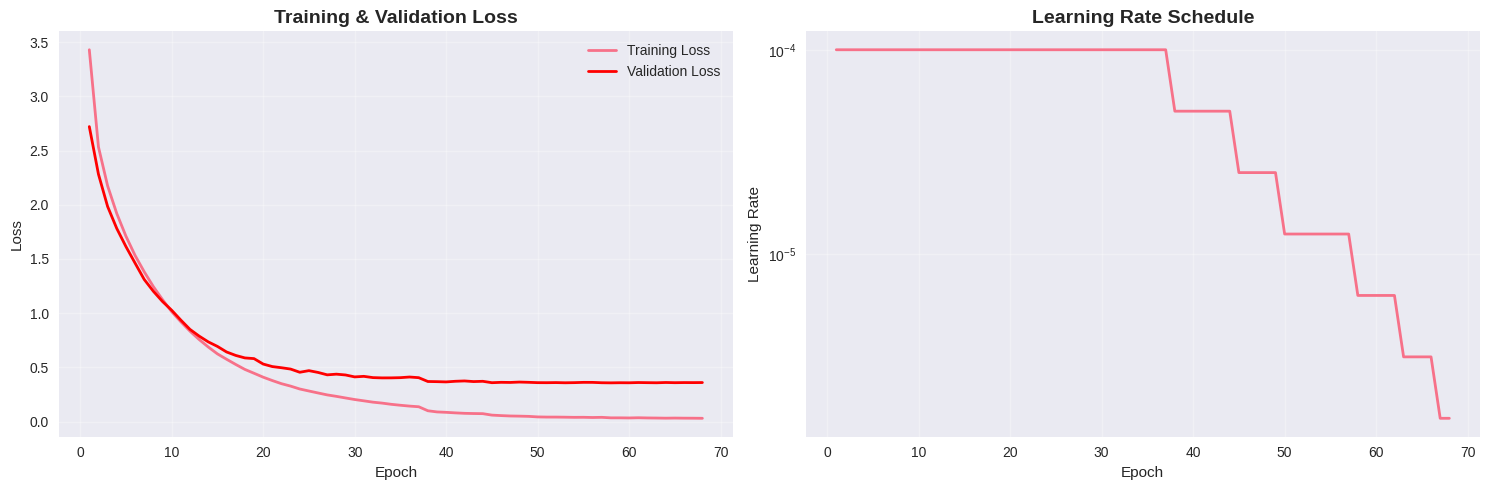

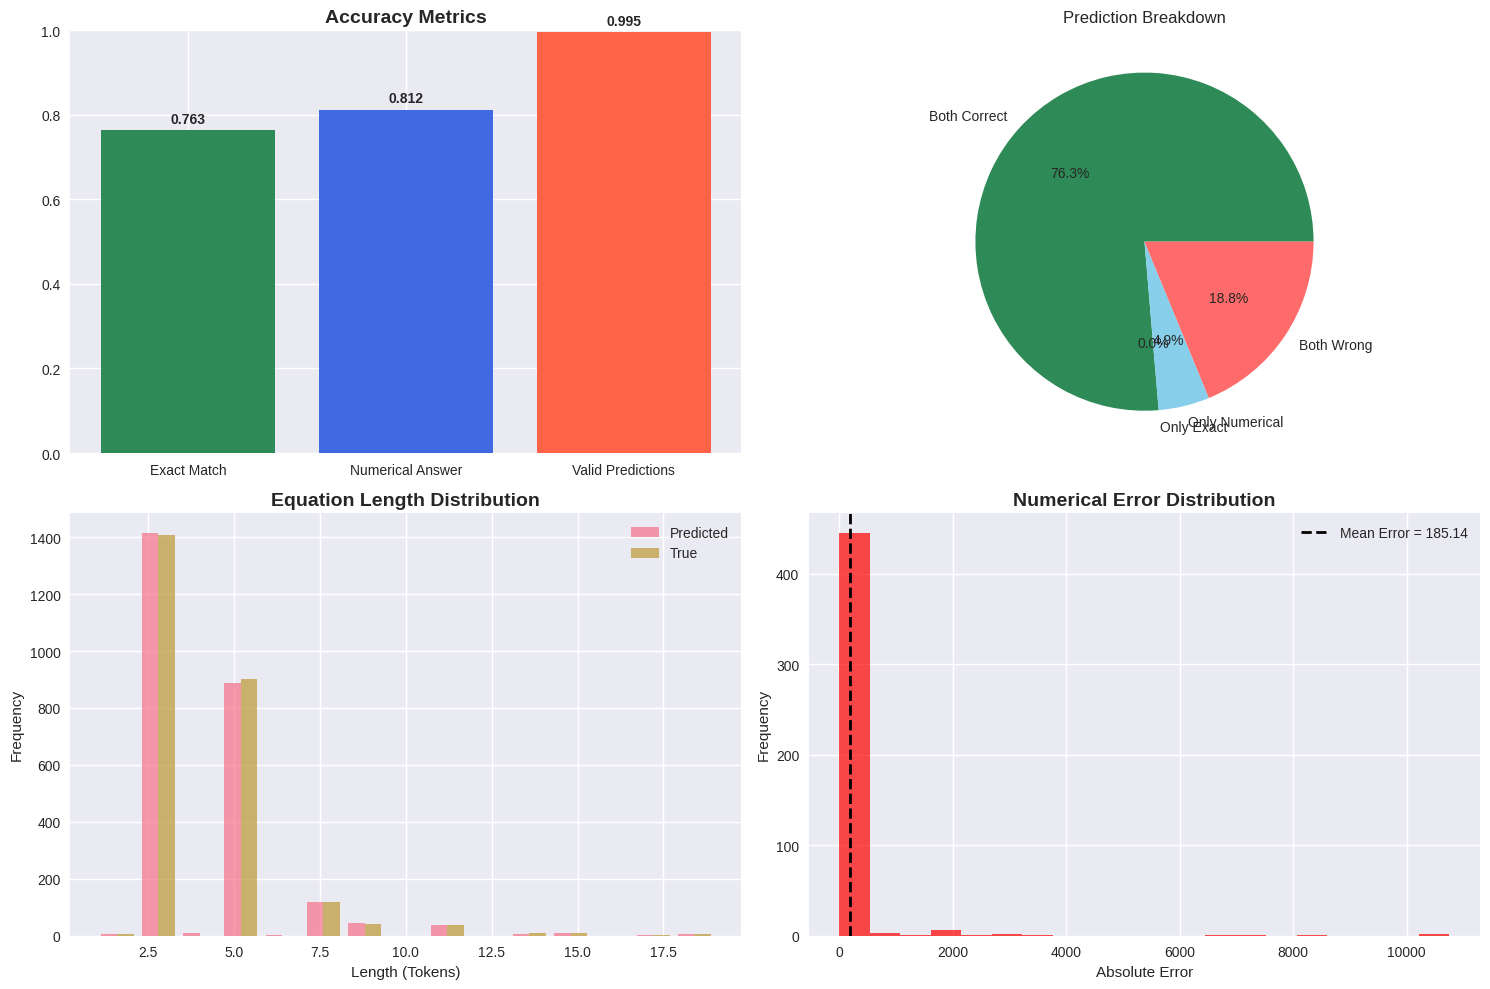


 SAMPLE PREDICTIONS TABLE
                                                        problem              predicted_equation                   true_equation  predicted_answer  true_answer  exact_match  numerical_match
Recently, AT&T introduced two long-distance telecommunicatio... / 4.95 - * 10.0 0.01 * 7.0 0.01 / 4.95 - * 10.0 0.01 * 7.0 0.01            165.00       165.00         True             True
You deposited 70 dollars in a savings account with an annual...         * * * 70.0 2.5 3.0 0.01         * * * 70.0 2.5 3.0 0.01              5.25         5.25         True             True
Barbara has 9 candies . She buys 18 more . How many candies ...                      + 9.0 18.0                      + 9.0 18.0             27.00        27.00         True             True
What is Frank's final score if he answers 3 questions correc...                 * 3.0 + 3.0 2.0                 * 3.0 + 3.0 2.0             15.00        15.00         True             True
After increasing by 2.86 fee

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import math

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ACCURACY CALCULATION

def calculate_detailed_accuracy(all_results):
    print("\n DETAILED ACCURACY ANALYSIS")
    print("=" * 80)

    total_samples = len(all_results)
    exact_matches = sum(r['exact_match'] for r in all_results)
    numerical_matches = sum(r['numerical_match'] for r in all_results)

    exact_accuracy = exact_matches / total_samples
    numerical_accuracy = numerical_matches / total_samples

    # Display
    print(f" Exact Match Accuracy:       {exact_accuracy:.4f} ({exact_matches}/{total_samples})")
    print(f" Numerical Answer Accuracy:  {numerical_accuracy:.4f} ({numerical_matches}/{total_samples})")

    # Valid outputs
    valid_predictions = sum(1 for r in all_results if not math.isnan(r['predicted_answer']))
    valid_accuracy = valid_predictions / total_samples

    print(f" Valid Predictions:          {valid_accuracy:.4f} ({valid_predictions}/{total_samples})")

    # Breakdown
    both_correct = sum(r['exact_match'] and r['numerical_match'] for r in all_results)
    only_exact_correct = sum(r['exact_match'] and not r['numerical_match'] for r in all_results)
    only_numerical_correct = sum(r['numerical_match'] and not r['exact_match'] for r in all_results)
    both_wrong = total_samples - (both_correct + only_exact_correct + only_numerical_correct)

    print("\n ERROR BREAKDOWN:")
    print(f"   Both Correct:           {both_correct}/{total_samples} ({both_correct/total_samples:.2%})")
    print(f"   Only Exact Correct:     {only_exact_correct}/{total_samples} ({only_exact_correct/total_samples:.2%})")
    print(f"   Only Numerical Correct: {only_numerical_correct}/{total_samples} ({only_numerical_correct/total_samples:.2%})")
    print(f"   Both Wrong:             {both_wrong}/{total_samples} ({both_wrong/total_samples:.2%})")

    return {
        'exact_accuracy': exact_accuracy,
        'numerical_accuracy': numerical_accuracy,
        'valid_accuracy': valid_accuracy,
        'both_correct': both_correct,
        'only_exact_correct': only_exact_correct,
        'only_numerical_correct': only_numerical_correct,
        'both_wrong': both_wrong,
        'total_samples': total_samples
    }

# 2. LOSS CURVE PLOTS

def plot_loss_curves(train_losses, val_losses, lr_history=None):
    """Plot training and validation loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    ax1.plot(epochs, train_losses, label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Learning Rate Plot
    if lr_history is not None:
        ax2.plot(range(1, len(lr_history) + 1), lr_history, linewidth=2)
        ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Learning Rate')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# 3. ACCURACY / ERROR VISUALIZATION

def plot_accuracy_comparison(metrics, all_results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # A. Accuracy Bar Chart

    acc_types = ['Exact Match', 'Numerical Answer', 'Valid Predictions']
    acc_values = [
        metrics['exact_accuracy'],
        metrics['numerical_accuracy'],
        metrics['valid_accuracy']
    ]

    bars = ax1.bar(acc_types, acc_values, color=['#2E8B57', '#4169E1', '#FF6347'])
    ax1.set_title('Accuracy Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1)

    for bar, v in zip(bars, acc_values):
        ax1.text(bar.get_x()+bar.get_width()/2., v+0.01, f"{v:.3f}",
                 ha='center', va='bottom', fontweight='bold')


    # Error Breakdown

    labels = ['Both Correct', 'Only Exact', 'Only Numerical', 'Both Wrong']
    sizes = [
        metrics['both_correct'],
        metrics['only_exact_correct'],
        metrics['only_numerical_correct'],
        metrics['both_wrong']
    ]
    colors = ['#2E8B57', '#90EE90', '#87CEEB', '#FF6B6B']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    ax2.set_title('Prediction Breakdown')


    # Equation length histograms

    pred_lengths = [len(r['predicted_equation'].split()) for r in all_results]
    true_lengths = [len(r['true_equation'].split()) for r in all_results]

    ax3.hist([pred_lengths, true_lengths], bins=15,
             label=['Predicted', 'True'], alpha=0.7)
    ax3.set_title('Equation Length Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Length (Tokens)')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    # Numerical error histogram

    numerical_errors = []
    for r in all_results:
        if (not r['numerical_match'] and
           not math.isnan(r['predicted_answer']) and
           not math.isnan(r['true_answer'])):
            numerical_errors.append(abs(r['predicted_answer'] - r['true_answer']))

    if numerical_errors:
        ax4.hist(numerical_errors, bins=20, alpha=0.7, color='red')
        ax4.axvline(np.mean(numerical_errors), linewidth=2, color='black',
                    linestyle='--', label=f"Mean Error = {np.mean(numerical_errors):.2f}")
        ax4.legend()
        ax4.set_title('Numerical Error Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Absolute Error')
        ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Call the plotting functions
metrics = calculate_detailed_accuracy(all_results)
plot_loss_curves(train_losses_global, val_losses_global, lr_history_global)
plot_accuracy_comparison(metrics, all_results)

# SAMPLE PREDICTIONS

print(f"\n{'='*80}")
print(" SAMPLE PREDICTIONS TABLE")
print(f"{'='*80}")

sample_df = pd.DataFrame(all_results[:10])
display_df = sample_df[['problem', 'predicted_equation', 'true_equation',
                        'predicted_answer', 'true_answer',
                        'exact_match', 'numerical_match']].copy()

# Shorten problem text
display_df['problem'] = display_df['problem'].apply(lambda x: x[:60] + "...")

print(display_df.to_string(index=False))


# **Hyperparameter Optimization + Stratified 5-fold CV**

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 13.3 MB/s eta 0:00:00


In [ ]:
!pip install optuna
import optuna
from optuna.trial import Trial
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset 
import copy

def objective(trial: Trial):
  
    lr = trial.suggest_float('lr', 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float('dropout_rate', 0.1, 0.5)
    num_attention_heads = trial.suggest_categorical('num_attention_heads', [4, 8, 16])
    decoder_embedding_dim_trial = trial.suggest_categorical('decoder_embedding_dim', [128, 256, 512])
    decoder_num_layers = trial.suggest_int('decoder_num_layers', 1, 4)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True)

    model_trial = MultimodalEquationPredictor(
        fusion_model=MultimodalFusionModel(
            t5_embedding_dim=t5_embedding_dim,
            gnn_embedding_dim=gnn_embedding_dim,
            fused_embedding_dim=fused_embedding_dim,
            num_attention_heads=num_attention_heads,
            dropout_rate=dropout_rate
        ),
        decoder_vocab_size=decoder_vocab_size,
        decoder_embedding_dim=decoder_embedding_dim_trial,
        decoder_hidden_dim=fused_embedding_dim,
        decoder_nhead=decoder_nhead,
        decoder_num_layers=decoder_num_layers,
        decoder_dim_feedforward=decoder_dim_feedforward,
        max_tgt_len=max_tgt_len,
        dropout_rate=dropout_rate
    ).to(device)

    # Optimizer with suggested parameters
    optimizer = torch.optim.AdamW(model_trial.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=0.5)

    # Create Subset datasets using the main `dataset` and indices
    train_dataset_optuna = Subset(dataset, train_idx)
    val_dataset_optuna   = Subset(dataset, val_idx)

    # Create DataLoaders using the correct collate_fn
    train_loader_optuna = DataLoader(train_dataset_optuna, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader_optuna   = DataLoader(val_dataset_optuna, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Training loop
    best_val_loss = float('inf')
    patience = 8
    patience_counter = 0

    for epoch in range(25):
        # Training
        model_trial.train()
        train_loss = 0
        for batch_idx, (t5_emb, gnn_emb, target_eq) in enumerate(train_loader_optuna):
            t5_emb, gnn_emb, target_eq = t5_emb.to(device), gnn_emb.to(device), target_eq.to(device)

            optimizer.zero_grad()
            decoder_input = target_eq[:, :-1]
            target_for_loss = target_eq[:, 1:]

            decoder_outputs = model_trial(t5_emb, gnn_emb, decoder_input)
            loss = loss_fn(decoder_outputs.contiguous().view(-1, decoder_vocab_size),
                          target_for_loss.contiguous().view(-1))

            loss.backward()
            torch.nn.utils.clip_grad_norm_(model_trial.parameters(), 1.0)
            optimizer.step()
            train_loss += loss.item()

        # Validation
        model_trial.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_idx, (t5_emb, gnn_emb, target_eq) in enumerate(val_loader_optuna):
                t5_emb, gnn_emb, target_eq = t5_emb.to(device), gnn_emb.to(device), target_eq.to(device)

                decoder_input = target_eq[:, :-1]
                target_for_loss = target_eq[:, 1:]

                decoder_outputs = model_trial(t5_emb, gnn_emb, decoder_input)
                loss = loss_fn(decoder_outputs.contiguous().view(-1, decoder_vocab_size),
                              target_for_loss.contiguous().view(-1))
                val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader_optuna)
        scheduler.step(avg_val_loss)

        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                break

    return best_val_loss

def run_hyperparameter_tuning(n_trials=50):
   
    print(" STARTING HYPERPARAMETER TUNING")
    print("=" * 60)

    study = optuna.create_study(
        direction='minimize',
        pruner=optuna.pruners.HyperbandPruner()
    )

    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    print("\nBEST HYPERPARAMETERS:")
    print("=" * 60)
    for key, value in study.best_trial.params.items():
        print(f"  {key}: {value}")

    print(f"\nBest validation loss: {study.best_value:.4f}")

    # Plot optimization history
    fig = optuna.visualization.plot_optimization_history(study)
    fig.show()

    # Plot parameter importance
    fig = optuna.visualization.plot_param_importances(study)
    fig.show()

    # Plot parallel coordinate
    fig = optuna.visualization.plot_parallel_coordinate(study)
    fig.show()

    return study.best_params


In [ ]:
best_params = run_hyperparameter_tuning(n_trials=20)

[I 2025-12-02 17:35:43,416] A new study created in memory with name: no-name-8276fffe-f149-4059-a3ff-4c27fade6f4b


 STARTING HYPERPARAMETER TUNING


  0%|          | 0/20 [00:00<?, ?it/s]

[I 2025-12-02 17:38:36,146] Trial 0 finished with value: 0.03065204751519559 and parameters: {'lr': 0.0001486507717750828, 'dropout_rate': 0.11011311132146129, 'num_attention_heads': 8, 'decoder_embedding_dim': 512, 'decoder_num_layers': 3, 'weight_decay': 0.00011887355716674214}. Best is trial 0 with value: 0.03065204751519559.
[I 2025-12-02 17:40:12,163] Trial 1 finished with value: 1.0102843001484871 and parameters: {'lr': 1.489610372589391e-05, 'dropout_rate': 0.32774453854653796, 'num_attention_heads': 8, 'decoder_embedding_dim': 512, 'decoder_num_layers': 1, 'weight_decay': 8.759694535729581e-06}. Best is trial 0 with value: 0.03065204751519559.
[I 2025-12-02 17:43:00,296] Trial 2 finished with value: 0.03803242386297825 and parameters: {'lr': 9.609111080756027e-05, 'dropout_rate': 0.2493086363123788, 'num_attention_heads': 16, 'decoder_embedding_dim': 512, 'decoder_num_layers': 3, 'weight_decay': 2.3540133404401657e-06}. Best is trial 0 with value: 0.03065204751519559.
[I 2025-1

In [ ]:
torch.save(model.state_dict(), "best_model_weights.pt")

In [55]:
best_params = {
    "lr": 0.0001486507717750828,
    "dropout_rate": 0.11011311132146129,
    "num_attention_heads": 8,
    "decoder_embedding_dim": 512,
    "decoder_num_layers": 3,
    "weight_decay": 0.00011887355716674214
}

## **Cross validation**

In [80]:
import os
import torch
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

def cross_validate_model(dataset, best_params, n_splits=5, epochs_per_fold=30):
    """Perform k-fold cross-validation and save best model for each fold"""

    # Create directory for saved models
    save_dir = "saved_models"
    os.makedirs(save_dir, exist_ok=True)

    print("STARTING K-FOLD CROSS VALIDATION")
    print("=" * 60)
    print(f"Folds: {n_splits}, Epochs per fold: {epochs_per_fold}")
    print("=" * 60)

    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    # Best hyperparameters from Optuna
    params = best_params

    for fold, (train_idx_cv, val_idx_cv) in enumerate(kfold.split(dataset)):
        print(f"\nFOLD {fold + 1}/{n_splits}")
        print("-" * 40)

        # Subsets
        train_subset_cv = Subset(dataset, train_idx_cv)
        val_subset_cv = Subset(dataset, val_idx_cv)

        # Dataloaders
        train_loader_cv = DataLoader(
            train_subset_cv, batch_size=32, shuffle=True, collate_fn=collate_fn
        )
        val_loader_cv = DataLoader(
            val_subset_cv, batch_size=32, shuffle=False, collate_fn=collate_fn
        )

        # -------------------------
        # Create model for this fold
        -------------------------
        model_cv = MultimodalEquationPredictor(
            fusion_model=MultimodalFusionModel(
                t5_embedding_dim=t5_embedding_dim,
                gnn_embedding_dim=gnn_embedding_dim,
                fused_embedding_dim=fused_embedding_dim,
                num_attention_heads=params.get("num_attention_heads", 8),
                dropout_rate=params.get("dropout_rate", 0.2)
            ),
            decoder_vocab_size=decoder_vocab_size,
            decoder_embedding_dim=params.get("decoder_embedding_dim", 256),
            decoder_hidden_dim=fused_embedding_dim,
            decoder_nhead=decoder_nhead,
            decoder_num_layers=params.get("decoder_num_layers", 3),
            decoder_dim_feedforward=decoder_dim_feedforward,
            max_tgt_len=max_tgt_len,
            dropout_rate=params.get("dropout_rate", 0.2)
        ).to(device)

        optimizer = torch.optim.AdamW(
            model_cv.parameters(),
            lr=params["lr"],
            weight_decay=params["weight_decay"]
        )

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
            optimizer, T_max=epochs_per_fold
        )

        fold_train_losses = []
        fold_val_losses = []

        best_val_loss = float("inf")
        best_model_path = os.path.join(save_dir, f"best_model_fold_{fold+1}.pt")

        # -------------------------
        # Training loop
        # -------------------------
        for epoch in range(epochs_per_fold):

            # TRAINING
            model_cv.train()
            train_loss = 0

            for t5_emb, gnn_emb, target_eq in train_loader_cv:
                t5_emb, gnn_emb, target_eq = (
                    t5_emb.to(device),
                    gnn_emb.to(device),
                    target_eq.to(device)
                )

                optimizer.zero_grad()

                decoder_input = target_eq[:, :-1]
                target_for_loss = target_eq[:, 1:]

                outputs = model_cv(t5_emb, gnn_emb, decoder_input)

                loss = loss_fn(
                    outputs.reshape(-1, decoder_vocab_size),
                    target_for_loss.reshape(-1)
                )

                loss.backward()
                torch.nn.utils.clip_grad_norm_(model_cv.parameters(), 1.0)
                optimizer.step()

                train_loss += loss.item()

            avg_train_loss = train_loss / len(train_loader_cv)
            fold_train_losses.append(avg_train_loss)

            # VALIDATION
            model_cv.eval()
            val_loss = 0

            with torch.no_grad():
                for t5_emb, gnn_emb, target_eq in val_loader_cv:
                    t5_emb, gnn_emb, target_eq = (
                        t5_emb.to(device),
                        gnn_emb.to(device),
                        target_eq.to(device)
                    )

                    decoder_input = target_eq[:, :-1]
                    target_for_loss = target_eq[:, 1:]

                    outputs = model_cv(t5_emb, gnn_emb, decoder_input)

                    loss = loss_fn(
                        outputs.reshape(-1, decoder_vocab_size),
                        target_for_loss.reshape(-1)
                    )

                    val_loss += loss.item()

            avg_val_loss = val_loss / len(val_loader_cv)
            fold_val_losses.append(avg_val_loss)

            scheduler.step()

            # SAVE BEST MODEL
            if avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                torch.save({
                    "model_state_dict": model_cv.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "val_loss": best_val_loss,
                    "fold": fold + 1,
                    "params": params
                }, best_model_path)

                print(f" Saved Best Model (Fold {fold+1}) — Val Loss: {best_val_loss:.4f}")

            # Logging
            if (epoch + 1) % 10 == 0:
                print(f"  Epoch {epoch+1}/{epochs_per_fold} | "
                      f"Train: {avg_train_loss:.4f} | Val: {avg_val_loss:.4f}")

        # -------------------------
        # Evaluation
        # -------------------------
        print(f"\nLoading best model for fold {fold+1} ...")
        checkpoint = torch.load(best_model_path)
        model_cv.load_state_dict(checkpoint["model_state_dict"])

        exact_acc, num_acc, _ = evaluate(model_cv, val_loader_cv, num_samples=0)

        fold_results.append({
            "fold": fold + 1,
            "best_val_loss": best_val_loss,
            "exact_accuracy": exact_acc,
            "numerical_accuracy": num_acc,
            "train_losses": fold_train_losses,
            "val_losses": fold_val_losses,
            "saved_model": best_model_path
        })

        print(f"Fold {fold+1} finished — Best Val Loss: {best_val_loss:.4f}")
        print(f"   Exact Accuracy: {exact_acc:.4f}")
        print(f"   Numerical Accuracy: {num_acc:.4f}")

    return fold_results


SyntaxError: invalid syntax (ipython-input-4209243090.py, line 42)

In [57]:
import matplotlib.pyplot as plt

def plot_cv_loss_curves(fold_results):

    plt.figure(figsize=(12, 6))

    for i, fold in enumerate(fold_results):
        epochs = range(1, len(fold['train_losses']) + 1)
        plt.plot(epochs, fold['train_losses'], label=f'Fold {i+1} Train', linestyle='-')
        plt.plot(epochs, fold['val_losses'], label=f'Fold {i+1} Val', linestyle='--')

    plt.title("K-Fold Training & Validation Loss Curves")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_cv_loss_curves(fold_results)

NameError: name 'fold_results' is not defined

## **Hyperparamter tuning**

TRAINING FINAL MODEL WITH OPTIMIZED HYPERPARAMETERS
Epoch 001/100 | Train Loss: 3.2818 | Val Loss: 2.5511 | LR: 1.49e-04 New best!
Epoch 010/100 | Train Loss: 0.8185 | Val Loss: 0.8080 | LR: 1.46e-04 New best!
Epoch 020/100 | Train Loss: 0.3243 | Val Loss: 0.4569 | LR: 1.36e-04 New best!
Epoch 030/100 | Train Loss: 0.1666 | Val Loss: 0.3948 | LR: 1.20e-04 New best!
Epoch 040/100 | Train Loss: 0.0980 | Val Loss: 0.3931 | LR: 9.95e-05 
Epoch 050/100 | Train Loss: 0.0584 | Val Loss: 0.3941 | LR: 7.67e-05 
Epoch 060/100 | Train Loss: 0.0379 | Val Loss: 0.3917 | LR: 5.36e-05 
Epoch 070/100 | Train Loss: 0.0255 | Val Loss: 0.3856 | LR: 3.25e-05 
Early stopping at epoch 74

Training completed! Best validation loss: 0.3815


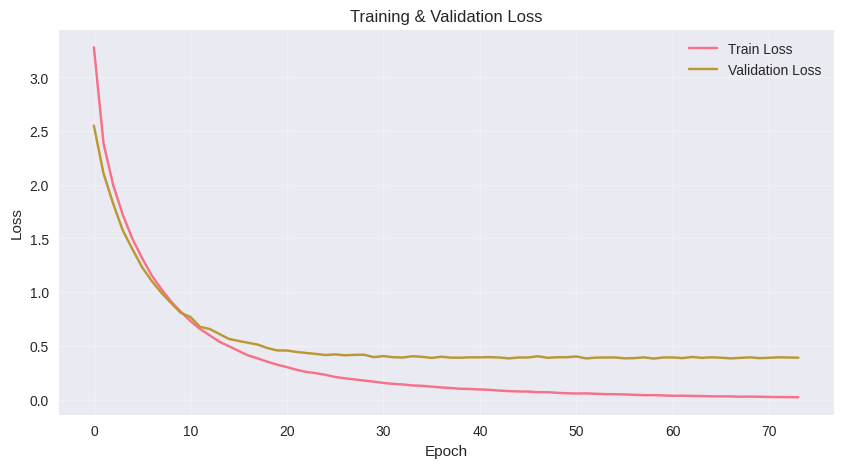

In [81]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

def train_final_model_with_best_params(best_params, epochs=100, patience=15):

    print("TRAINING FINAL MODEL WITH OPTIMIZED HYPERPARAMETERS")
    print("=" * 70)

    # Create model
    final_model = MultimodalEquationPredictor(
        fusion_model=MultimodalFusionModel(
            t5_embedding_dim=t5_embedding_dim,
            gnn_embedding_dim=gnn_embedding_dim,
            fused_embedding_dim=fused_embedding_dim,
            num_attention_heads=best_params.get('num_attention_heads', 8),
            dropout_rate=best_params.get('dropout_rate', 0.2)
        ),
        decoder_vocab_size=decoder_vocab_size,
        decoder_embedding_dim=256,
        decoder_hidden_dim=fused_embedding_dim,
        decoder_nhead=decoder_nhead,
        decoder_num_layers=best_params.get('decoder_num_layers', 3),
        decoder_dim_feedforward=decoder_dim_feedforward,
        max_tgt_len=max_tgt_len,
        dropout_rate=best_params.get('dropout_rate', 0.2)
    ).to(device)

    # Optimizer & scheduler
    optimizer = torch.optim.AdamW(
        final_model.parameters(),
        lr=best_params.get('lr', 1e-4),
        weight_decay=best_params.get('weight_decay', 0.01)
    )
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    # Track losses & LR
    train_losses, val_losses, lr_history = [], [], []

    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        # Training
        final_model.train()
        total_train_loss = 0
        for t5_emb, gnn_emb, target_eq in train_loader:
            t5_emb, gnn_emb, target_eq = t5_emb.to(device), gnn_emb.to(device), target_eq.to(device)

            optimizer.zero_grad()
            decoder_input = target_eq[:, :-1]
            target_for_loss = target_eq[:, 1:]

            decoder_outputs = final_model(t5_emb, gnn_emb, decoder_input)
            loss = loss_fn(decoder_outputs.contiguous().view(-1, decoder_vocab_size),
                           target_for_loss.contiguous().view(-1))
            loss.backward()
            torch.nn.utils.clip_grad_norm_(final_model.parameters(), 1.0)
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # Validation
        final_model.eval()
        total_val_loss = 0
        with torch.no_grad():
            for t5_emb, gnn_emb, target_eq in val_loader:
                t5_emb, gnn_emb, target_eq = t5_emb.to(device), gnn_emb.to(device), target_eq.to(device)
                decoder_input = target_eq[:, :-1]
                target_for_loss = target_eq[:, 1:]

                decoder_outputs = final_model(t5_emb, gnn_emb, decoder_input)
                loss = loss_fn(decoder_outputs.contiguous().view(-1, decoder_vocab_size),
                               target_for_loss.contiguous().view(-1))
                total_val_loss += loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        lr_history.append(optimizer.param_groups[0]['lr'])

        # Scheduler step
        scheduler.step()

        # Early stopping & best model saving
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            torch.save(final_model.state_dict(), "best_final_model.pt")
            patience_counter = 0
            improvement = "New best!"
        else:
            patience_counter += 1
            improvement = ""

        if (epoch + 1) % 10 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:03d}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | LR: {lr_history[-1]:.2e} {improvement}")

        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    print(f"\nTraining completed! Best validation loss: {best_val_loss:.4f}")

    # Plot loss curves
    plt.figure(figsize=(10,5))
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return final_model, train_losses, val_losses, lr_history

# Usage
final_model, train_losses, val_losses, lr_history = train_final_model_with_best_params(best_params)


In [91]:
torch.save(final_model.state_dict(), "best_final_model.pt")



Loading model...

Rebuilding model architecture...
Loading checkpoint weights...
Model successfully loaded from: /content/best_final_model.pt

Running evaluation...

EVALUATION RESULTS

SAMPLE 1
────────────────────────────────────────────────────────────────────────────────
Problem: Recently, AT&T introduced two long-distance telecommunication plans. The Rate Plus Plan has a monthly charge of 4.95 dollars with an extra charge of 7 cents for every minute of use. The second plan has no monthly payment, but costs 10 cents for every minute of usage. For what length of phone use will both policies have the same expense?
────────────────────────────────────────────────────────────────────────────────
Predicted Equation: / 4.95 - * 10.0 0.01 * 7.0 0.01
True Equation:      / 4.95 - * 10.0 0.01 * 7.0 0.01
Predicted Answer:   165.0
True Answer:        165.0
Exact Match:        Correct
Numerical Match:    Correct
────────────────────────────────────────────────────────────────────────────────



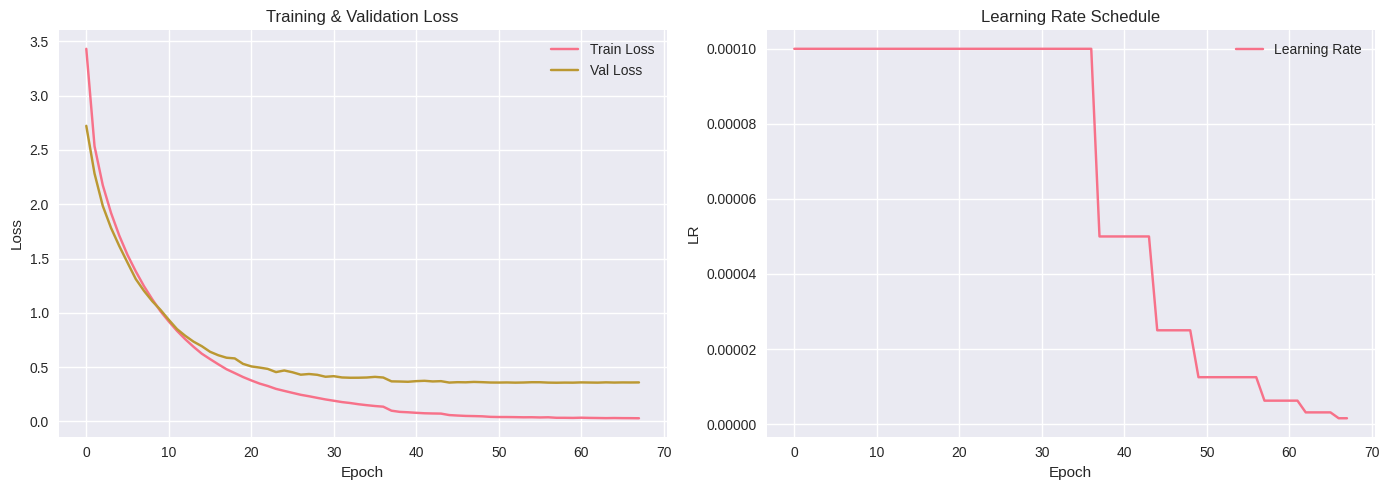

In [93]:
import torch
import torch.nn as nn
import math
import matplotlib.pyplot as plt

# ====================================================
# 1) LOAD SAVED MODEL (Rebuild architecture + load weights)
# ====================================================
def load_model(checkpoint_path, device='cuda'):

    print("\nRebuilding model architecture...")

    model = MultimodalEquationPredictor(
        fusion_model=MultimodalFusionModel(
            t5_embedding_dim=t5_embedding_dim,
            gnn_embedding_dim=gnn_embedding_dim,
            fused_embedding_dim=fused_embedding_dim,
            num_attention_heads=best_params.get('num_attention_heads', 8),
            dropout_rate=best_params.get('dropout_rate', 0.2)
        ),
        decoder_vocab_size=decoder_vocab_size,
        decoder_embedding_dim=256,
        decoder_hidden_dim=fused_embedding_dim,
        decoder_nhead=decoder_nhead,
        decoder_num_layers=best_params.get('decoder_num_layers', 3),
        decoder_dim_feedforward=decoder_dim_feedforward,
        max_tgt_len=max_tgt_len,
        dropout_rate=best_params.get('dropout_rate', 0.2)
    ).to(device)

    print("Loading checkpoint weights...")
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.eval()

    print(f"Model successfully loaded from: {checkpoint_path}")
    return model


# ====================================================
# 2) EVALUATION LOOP
# ====================================================
def evaluate(model, test_loader, num_samples=15):
    exact_match_count = 0
    numerical_accuracy_count = 0
    total_samples = 0

    print("\nEVALUATION RESULTS")
    print("=" * 120)

    all_results = []

    for batch_idx, (t5_emb_batch, gnn_emb_batch, target_eq_batch) in enumerate(test_loader):

        for j in range(t5_emb_batch.shape[0]):

            try:
                if total_samples >= len(test_dataset):
                    break

                t5_emb = t5_emb_batch[j]
                gnn_emb = gnn_emb_batch[j]

                dataset_idx = (
                    test_dataset.indices[total_samples]
                    if hasattr(test_dataset, 'indices')
                    else total_samples
                )
                problem_text = df.iloc[dataset_idx]['Problem']

                # Prediction
                predicted = beam_search(model, t5_emb, gnn_emb)

                truth = target_eq_batch[j].tolist()
                truth = [t for t in truth if t != stoi['<pad>']]

                predicted_clean = [
                    t for t in predicted
                    if t not in (stoi['<sos>'], stoi['<eos>'], stoi['<pad>'])
                ]
                truth_clean = [
                    t for t in truth
                    if t not in (stoi['<sos>'], stoi['<eos>'])
                ]

                pred_str = " ".join([itos[t] for t in predicted_clean])
                truth_str = " ".join([itos[t] for t in truth_clean])

                pred_ans = evaluate_prefix(predicted_clean, itos)
                truth_ans = evaluate_prefix(truth_clean, itos)

                exact_match = predicted_clean == truth_clean
                numerical_match = (
                    not math.isnan(pred_ans) and
                    not math.isnan(truth_ans) and
                    abs(pred_ans - truth_ans) < tolerance
                )

                if exact_match:
                    exact_match_count += 1
                if numerical_match:
                    numerical_accuracy_count += 1

                result = {
                    "problem": problem_text,
                    "predicted_equation": pred_str,
                    "true_equation": truth_str,
                    "predicted_answer": pred_ans,
                    "true_answer": truth_ans,
                    "exact_match": exact_match,
                    "numerical_match": numerical_match
                }
                all_results.append(result)

                if total_samples < num_samples:
                    print(f"\nSAMPLE {total_samples + 1}")
                    print("─" * 80)
                    print(f"Problem: {problem_text}")
                    print("─" * 80)
                    print(f"Predicted Equation: {pred_str}")
                    print(f"True Equation:      {truth_str}")
                    print(f"Predicted Answer:   {pred_ans}")
                    print(f"True Answer:        {truth_ans}")
                    print(f"Exact Match:        {'Correct' if exact_match else 'Incorrect'}")
                    print(f"Numerical Match:    {'Correct' if numerical_match else 'Incorrect'}")
                    print("─" * 80)

                total_samples += 1

            except Exception as e:
                print(f"Error processing sample {total_samples}: {e}")
                total_samples += 1
                continue

    exact_acc = exact_match_count / total_samples
    num_acc = numerical_accuracy_count / total_samples

    print("\n" + "=" * 120)
    print("FINAL RESULTS SUMMARY")
    print("=" * 120)
    print(f"Exact Match Accuracy:        {exact_acc:.4f} ({exact_match_count}/{total_samples})")
    print(f"Numerical Answer Accuracy:   {num_acc:.4f} ({numerical_accuracy_count}/{total_samples})")

    return exact_acc, num_acc, all_results


# ====================================================
# 3) PLOT TRAINING LOSS + LR HISTORY
# ====================================================
def plot_history(train_losses, val_losses, lr_history):
    plt.figure(figsize=(14, 5))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Training & Validation Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(lr_history, label="Learning Rate")
    plt.xlabel("Epoch")
    plt.ylabel("LR")
    plt.title("Learning Rate Schedule")
    plt.legend()

    plt.tight_layout()
    plt.show()


# ====================================================
# 4) MAIN PIPELINE: LOAD → EVALUATE → PLOT
# ====================================================
device = "cuda"

print("\nLoading model...")
model = load_model("/content/best_final_model.pt", device)

print("\nRunning evaluation...")
exact_acc, num_acc, all_results = evaluate(model, test_loader)

print("\nPlotting training history...")
plot_history(train_losses_global, val_losses_global, lr_history_global)



 DETAILED ACCURACY ANALYSIS
 Exact Match Accuracy:       0.7799 (1981/2540)
 Numerical Answer Accuracy:  0.8283 (2104/2540)
 Valid Predictions:          0.9957 (2529/2540)

 ERROR BREAKDOWN:
   Both Correct:           1981/2540 (77.99%)
   Only Exact Correct:     0/2540 (0.00%)
   Only Numerical Correct: 123/2540 (4.84%)
   Both Wrong:             436/2540 (17.17%)


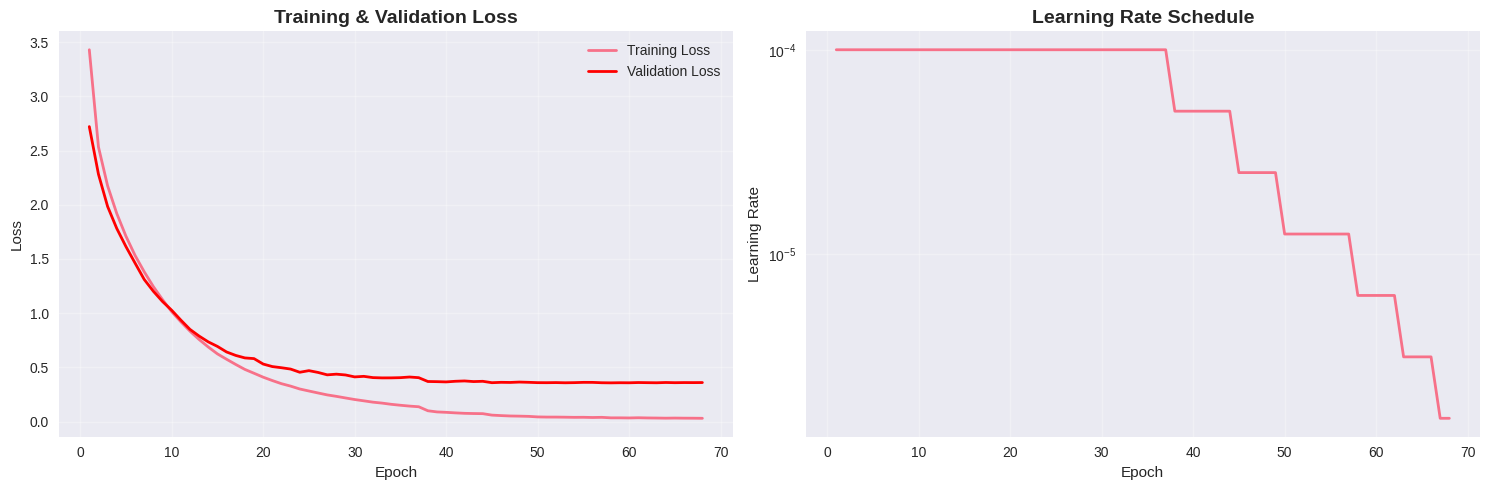

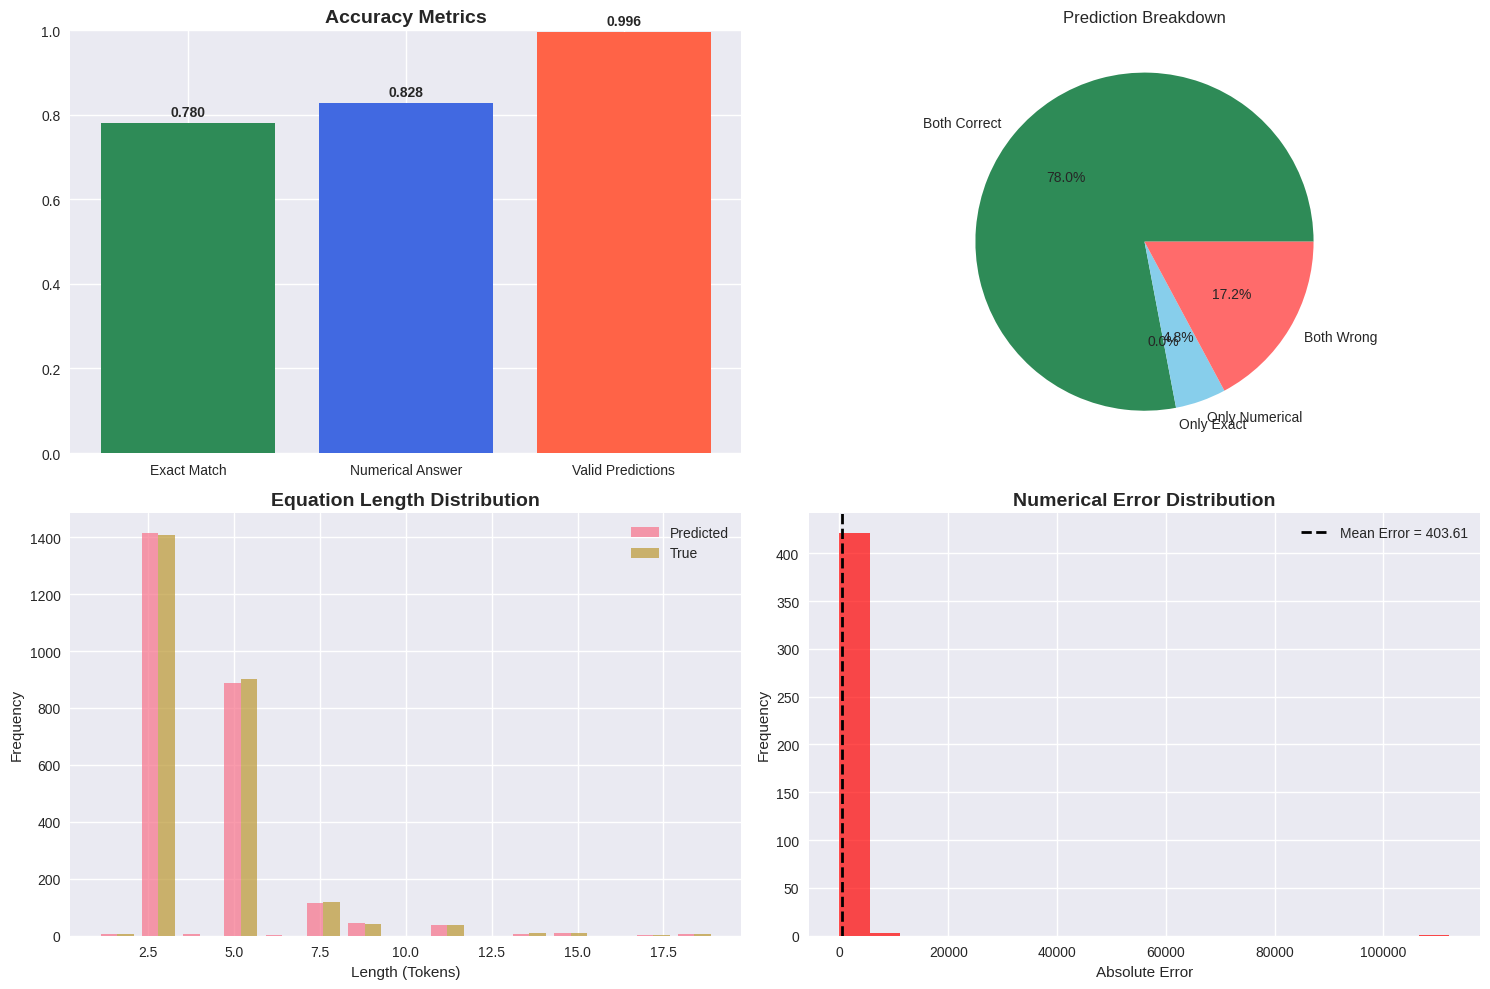


 SAMPLE PREDICTIONS TABLE
                                                        problem              predicted_equation                   true_equation  predicted_answer  true_answer  exact_match  numerical_match
Recently, AT&T introduced two long-distance telecommunicatio... / 4.95 - * 10.0 0.01 * 7.0 0.01 / 4.95 - * 10.0 0.01 * 7.0 0.01            165.00       165.00         True             True
You deposited 70 dollars in a savings account with an annual...         * * * 70.0 2.5 3.0 0.01         * * * 70.0 2.5 3.0 0.01              5.25         5.25         True             True
Barbara has 9 candies . She buys 18 more . How many candies ...                      + 9.0 18.0                      + 9.0 18.0             27.00        27.00         True             True
What is Frank's final score if he answers 3 questions correc...                 * 3.0 + 3.0 2.0                 * 3.0 + 3.0 2.0             15.00        15.00         True             True
After increasing by 2.86 fee

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import math

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# ACCURACY CALCULATION

def calculate_detailed_accuracy(all_results):
    print("\n DETAILED ACCURACY ANALYSIS")
    print("=" * 80)

    total_samples = len(all_results)
    exact_matches = sum(r['exact_match'] for r in all_results)
    numerical_matches = sum(r['numerical_match'] for r in all_results)

    exact_accuracy = exact_matches / total_samples
    numerical_accuracy = numerical_matches / total_samples

    # Display
    print(f" Exact Match Accuracy:       {exact_accuracy:.4f} ({exact_matches}/{total_samples})")
    print(f" Numerical Answer Accuracy:  {numerical_accuracy:.4f} ({numerical_matches}/{total_samples})")

    # Valid outputs
    valid_predictions = sum(1 for r in all_results if not math.isnan(r['predicted_answer']))
    valid_accuracy = valid_predictions / total_samples

    print(f" Valid Predictions:          {valid_accuracy:.4f} ({valid_predictions}/{total_samples})")

    # Breakdown
    both_correct = sum(r['exact_match'] and r['numerical_match'] for r in all_results)
    only_exact_correct = sum(r['exact_match'] and not r['numerical_match'] for r in all_results)
    only_numerical_correct = sum(r['numerical_match'] and not r['exact_match'] for r in all_results)
    both_wrong = total_samples - (both_correct + only_exact_correct + only_numerical_correct)

    print("\n ERROR BREAKDOWN:")
    print(f"   Both Correct:           {both_correct}/{total_samples} ({both_correct/total_samples:.2%})")
    print(f"   Only Exact Correct:     {only_exact_correct}/{total_samples} ({only_exact_correct/total_samples:.2%})")
    print(f"   Only Numerical Correct: {only_numerical_correct}/{total_samples} ({only_numerical_correct/total_samples:.2%})")
    print(f"   Both Wrong:             {both_wrong}/{total_samples} ({both_wrong/total_samples:.2%})")

    return {
        'exact_accuracy': exact_accuracy,
        'numerical_accuracy': numerical_accuracy,
        'valid_accuracy': valid_accuracy,
        'both_correct': both_correct,
        'only_exact_correct': only_exact_correct,
        'only_numerical_correct': only_numerical_correct,
        'both_wrong': both_wrong,
        'total_samples': total_samples
    }

# 2. LOSS CURVE PLOTS

def plot_loss_curves(train_losses, val_losses, lr_history=None):
    """Plot training and validation loss curves"""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    epochs = range(1, len(train_losses) + 1)

    # Loss Plot
    ax1.plot(epochs, train_losses, label='Training Loss', linewidth=2)
    ax1.plot(epochs, val_losses, label='Validation Loss', linewidth=2, color='red')
    ax1.set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Learning Rate Plot
    if lr_history is not None:
        ax2.plot(range(1, len(lr_history) + 1), lr_history, linewidth=2)
        ax2.set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Learning Rate')
        ax2.set_yscale('log')
        ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()


# 3. ACCURACY / ERROR VISUALIZATION

def plot_accuracy_comparison(metrics, all_results):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

    # A. Accuracy Bar Chart

    acc_types = ['Exact Match', 'Numerical Answer', 'Valid Predictions']
    acc_values = [
        metrics['exact_accuracy'],
        metrics['numerical_accuracy'],
        metrics['valid_accuracy']
    ]

    bars = ax1.bar(acc_types, acc_values, color=['#2E8B57', '#4169E1', '#FF6347'])
    ax1.set_title('Accuracy Metrics', fontsize=14, fontweight='bold')
    ax1.set_ylim(0, 1)

    for bar, v in zip(bars, acc_values):
        ax1.text(bar.get_x()+bar.get_width()/2., v+0.01, f"{v:.3f}",
                 ha='center', va='bottom', fontweight='bold')


    # Error Breakdown

    labels = ['Both Correct', 'Only Exact', 'Only Numerical', 'Both Wrong']
    sizes = [
        metrics['both_correct'],
        metrics['only_exact_correct'],
        metrics['only_numerical_correct'],
        metrics['both_wrong']
    ]
    colors = ['#2E8B57', '#90EE90', '#87CEEB', '#FF6B6B']

    ax2.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%')
    ax2.set_title('Prediction Breakdown')


    # Equation length histograms

    pred_lengths = [len(r['predicted_equation'].split()) for r in all_results]
    true_lengths = [len(r['true_equation'].split()) for r in all_results]

    ax3.hist([pred_lengths, true_lengths], bins=15,
             label=['Predicted', 'True'], alpha=0.7)
    ax3.set_title('Equation Length Distribution', fontsize=14, fontweight='bold')
    ax3.set_xlabel('Length (Tokens)')
    ax3.set_ylabel('Frequency')
    ax3.legend()

    # Numerical error histogram

    numerical_errors = []
    for r in all_results:
        if (not r['numerical_match'] and
           not math.isnan(r['predicted_answer']) and
           not math.isnan(r['true_answer'])):
            numerical_errors.append(abs(r['predicted_answer'] - r['true_answer']))

    if numerical_errors:
        ax4.hist(numerical_errors, bins=20, alpha=0.7, color='red')
        ax4.axvline(np.mean(numerical_errors), linewidth=2, color='black',
                    linestyle='--', label=f"Mean Error = {np.mean(numerical_errors):.2f}")
        ax4.legend()
        ax4.set_title('Numerical Error Distribution', fontsize=14, fontweight='bold')
        ax4.set_xlabel('Absolute Error')
        ax4.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

# Call the plotting functions
metrics = calculate_detailed_accuracy(all_results)
plot_loss_curves(train_losses_global, val_losses_global, lr_history_global)
plot_accuracy_comparison(metrics, all_results)

# SAMPLE PREDICTIONS

print(f"\n{'='*80}")
print(" SAMPLE PREDICTIONS TABLE")
print(f"{'='*80}")

sample_df = pd.DataFrame(all_results[:10])
display_df = sample_df[['problem', 'predicted_equation', 'true_equation',
                        'predicted_answer', 'true_answer',
                        'exact_match', 'numerical_match']].copy()

# Shorten problem text
display_df['problem'] = display_df['problem'].apply(lambda x: x[:60] + "...")

print(display_df.to_string(index=False))
